## Setup, Loading Data and CDFs

In [3]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'green'

In [4]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_wavelet_full_agriVision.ipynb


In [5]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/green'

In [6]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [7]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [8]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


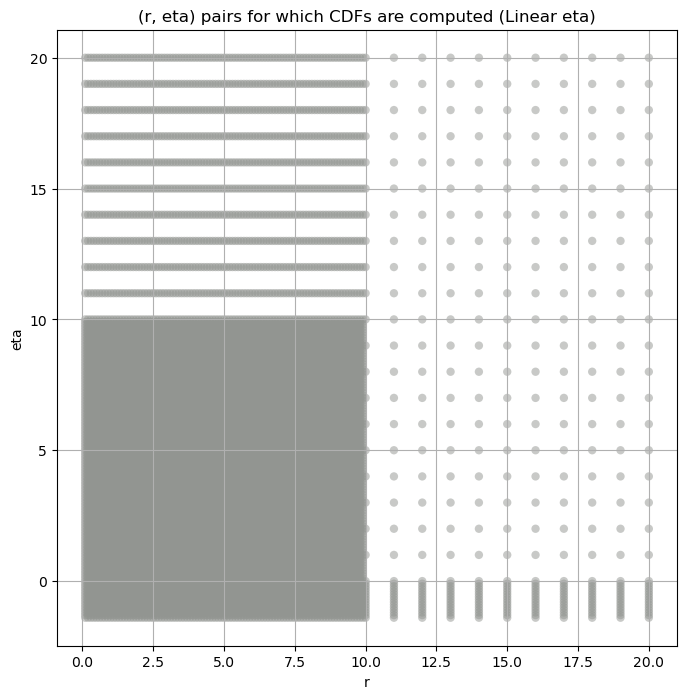

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [9]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [10]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [11]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:30<00:00, 3284.35it/s]


Layer 3


100%|██████████| 100000/100000 [00:31<00:00, 3211.30it/s]


Layer 4


100%|██████████| 100000/100000 [00:28<00:00, 3487.36it/s]


Layer 5


100%|██████████| 100000/100000 [00:28<00:00, 3489.75it/s]


Layer 6


100%|██████████| 100000/100000 [00:28<00:00, 3471.20it/s]


Layer 7


100%|██████████| 100000/100000 [00:28<00:00, 3569.92it/s]


Layer 8


100%|██████████| 100000/100000 [00:28<00:00, 3516.70it/s]


Layer 9


100%|██████████| 100000/100000 [00:26<00:00, 3788.82it/s]


Layer 10


100%|██████████| 100000/100000 [00:26<00:00, 3761.27it/s]


obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2      181300.620000  101526.980000  290784.600000   377.25858  142.297880   
3       38789.977000   21575.424000   67721.520000   543.33215  122.402770   
4        9777.212000    4939.198000   17950.002000   703.37980  122.038475   
5        1796.315800     838.102050    4289.250000  1421.50900   90.012470   
6         385.116970     175.524030    1132.752800  2320.62400   86.752716   
7         101.065820      41.339350     424.445160  4759.82570   66.990580   
8          34.402660      17.916046      89.423820  1601.38330   74.529690   
9           9.889628       5.271114      25.139076  1503.44800   80.922005   
10          1.436547       0.712656       4.498758  2683.97460   76.523470   

       kurt_upper  total_samples  
layer                             
2       530.93066         9000.0  
3      1044.48300        36000.0  
4      1327.72410       144000.0  
5      3420.72660       576000.0  
6      4403.35350      2304000.0  
7      6336.49370      9216000.0  
8      3574.43000     36864000.0  
9      3413.64060    147456000.0  
10     4568.20360    589824000.0

## Initial Grid Search and Hypothesis Test Plots

In [12]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [13]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      181300.620000  181300.625000    53445.761719    45005.449219   
3       38789.977000   38789.976562    16658.687500    13901.541992   
4        9777.212000    9777.211914     5205.545898     4225.368652   
5        1796.315800    1796.315796      877.927307      739.463196   
6         385.116970     385.116974      184.443924      155.674011   
7         101.065820     101.065819       43.042274       37.106045   
8          34.402660      34.402660       18.636578       15.866291   
9           9.889628       9.889628        5.496773        4.640526   
10          1.436547       1.436547        0.749907        0.638147   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        39764.796875     35826.734375     29935.513672     25676.970703   
3        12451.002930     11435.936523     10024.461914      9036.481445   
4         3702.062500      3371.920898      2965.602051      2685.470947   
5          660.932312       608.944031       539.713257       493.018890   
6          139.582962       128.890839       114.929863       105.545555   
7           33.801170        31.587860        28.652582        26.685877   
8           14.410324        13.484938        12.334513        11.597518   
9            4.198738         3.922556         3.574429         3.344842   
10           0.578338         0.539444         0.488902         0.455188   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         22347.328125     19796.238281     17737.550781     13339.284180  
3          8276.508789      7653.468750      7134.844727      5996.588379  
4          2475.111816      2312.419189      2181.540283      1889.140747  
5           457.912842       429.708984       406.282227       353.609497  
6            98.496643        92.853760        88.197052        77.909477  
7            25.226458        24.069267        23.111481        20.952288  
8            11.049390        10.608252        10.236454         9.369349  
9             3.171036         3.029906         2.910432         2.631124  
10            0.429662         0.409041         0.391678         0.351231

####
Layer  2


100%|██████████| 12760/12760 [00:07<00:00, 1768.74it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.02488323158856398 181300.62


100%|██████████| 12760/12760 [00:04<00:00, 2684.05it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.013815792407346872 53445.76


100%|██████████| 12760/12760 [00:04<00:00, 2855.50it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.013746479136173329 45005.45


100%|██████████| 12760/12760 [00:04<00:00, 2826.33it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.014614397029402815 39764.797


100%|██████████| 12760/12760 [00:04<00:00, 2615.11it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.016400842818956263 35826.734


100%|██████████| 12760/12760 [00:04<00:00, 2797.41it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.02157105915550077 29935.514


100%|██████████| 12760/12760 [00:04<00:00, 2740.15it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.026886220347592693 25676.97


100%|██████████| 12760/12760 [00:04<00:00, 2635.63it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.03277642534983288 22347.328


100%|██████████| 12760/12760 [00:04<00:00, 2749.78it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.03792318163919148 19796.238


100%|██████████| 12760/12760 [00:04<00:00, 2683.76it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.043605163733430756 17737.55


100%|██████████| 12760/12760 [00:04<00:00, 2775.50it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.05857588592736771 13339.284
Number of samples: 9000, Without approximation : 9000.0


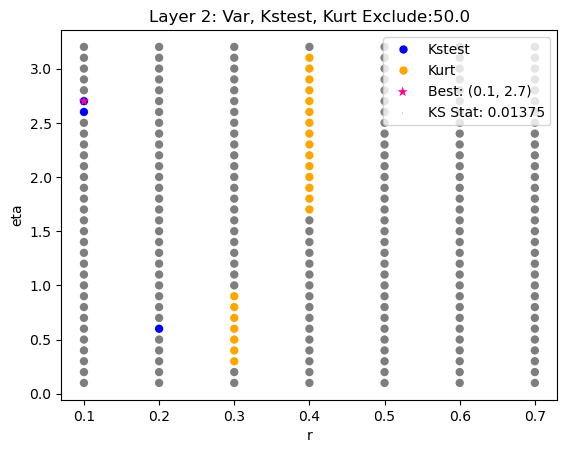

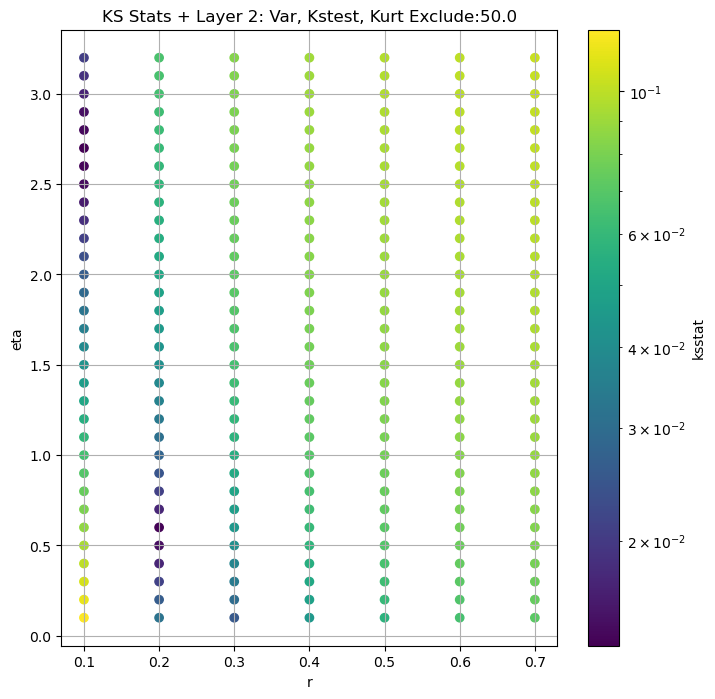

####
Layer  3


100%|██████████| 12760/12760 [00:16<00:00, 787.96it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.028424359622288953 38789.977


100%|██████████| 12760/12760 [00:16<00:00, 784.32it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.014304278962454675 16658.688


100%|██████████| 12760/12760 [00:16<00:00, 782.15it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.010495641286026647 13901.542


100%|██████████| 12760/12760 [00:16<00:00, 790.22it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.009559196964629146 12451.003


100%|██████████| 12760/12760 [00:15<00:00, 800.51it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.009506968892990963 11435.937


100%|██████████| 12760/12760 [00:16<00:00, 796.19it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.009030392608931348 10024.462


100%|██████████| 12760/12760 [00:16<00:00, 768.96it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.010030634322003802 9036.481


100%|██████████| 12760/12760 [00:16<00:00, 791.95it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.01140429759895855 8276.509


100%|██████████| 12760/12760 [00:15<00:00, 800.94it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.012642500923787471 7653.4688


100%|██████████| 12760/12760 [00:16<00:00, 790.19it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.01422089308482545 7134.8447


100%|██████████| 12760/12760 [00:15<00:00, 799.45it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.01842700287978091 5996.5884
Number of samples: 36000, Without approximation : 36000.0


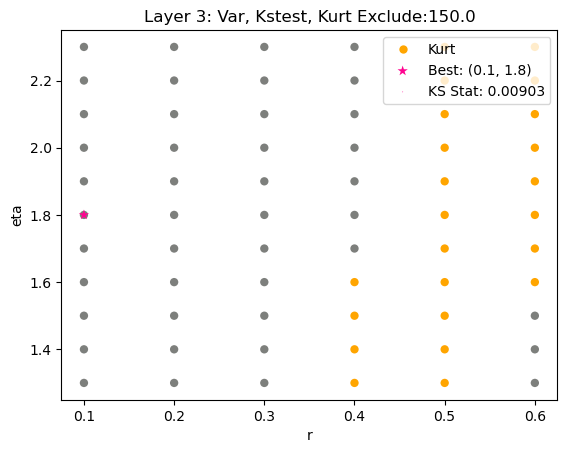

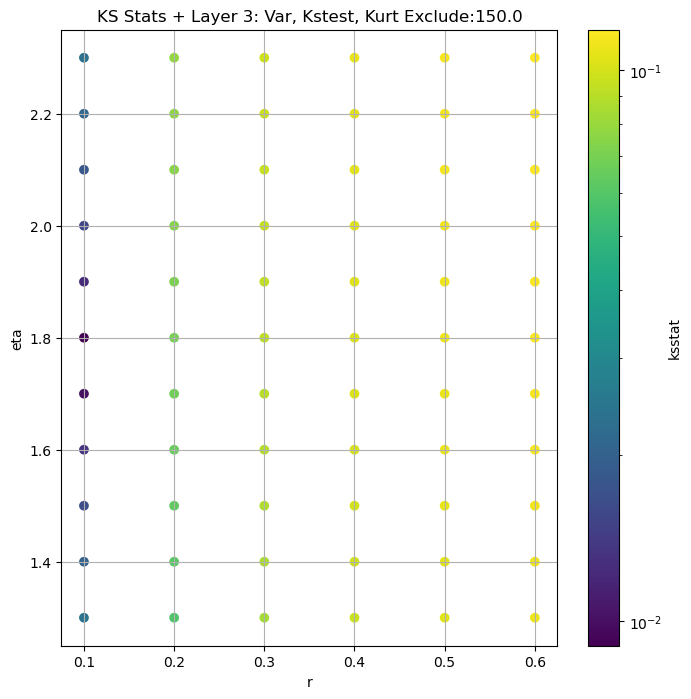

####
Layer  4


100%|██████████| 12760/12760 [00:46<00:00, 275.53it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.03446076685886135 9777.212


100%|██████████| 12760/12760 [00:45<00:00, 280.39it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.022670991835502807 5205.546


100%|██████████| 12760/12760 [00:46<00:00, 276.68it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.019086951219507653 4225.3687


100%|██████████| 12760/12760 [00:46<00:00, 275.95it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.016593197743063892 3702.0625


100%|██████████| 12760/12760 [00:46<00:00, 276.03it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.015468621070975797 3371.921


100%|██████████| 12760/12760 [00:45<00:00, 279.61it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.011821398690036844 2965.602


100%|██████████| 12760/12760 [00:45<00:00, 279.70it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.011543632738808207 2685.471


100%|██████████| 12760/12760 [00:45<00:00, 280.46it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.00898390756318812 2475.1118


100%|██████████| 12760/12760 [00:45<00:00, 280.96it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.007627841040872441 2312.4192


100%|██████████| 12760/12760 [00:45<00:00, 281.74it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.006964605775686472 2181.5403


100%|██████████| 12760/12760 [00:45<00:00, 279.76it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.008726201318673743 1889.1407
Number of samples: 100000, Without approximation : 144000.0


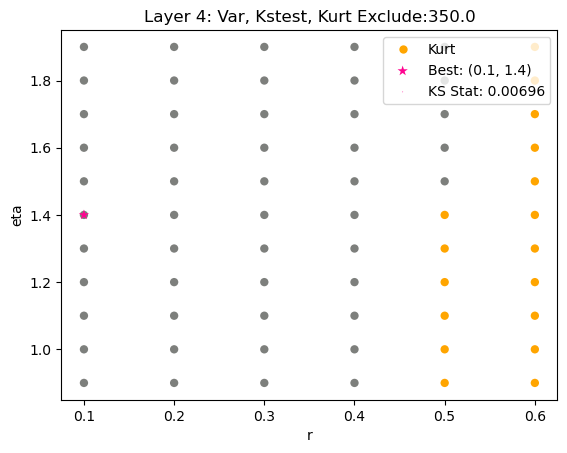

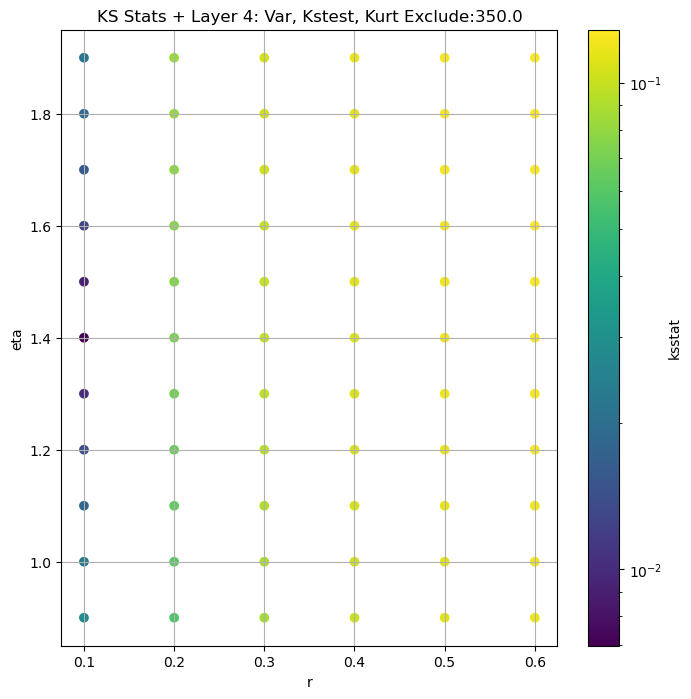

####
Layer  5


100%|██████████| 12760/12760 [00:45<00:00, 280.65it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.033584663406318715 1796.3158


100%|██████████| 12760/12760 [00:45<00:00, 277.43it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.019172153316739493 877.9273


100%|██████████| 12760/12760 [00:46<00:00, 274.29it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.01615896967443531 739.4632


100%|██████████| 12760/12760 [00:46<00:00, 273.79it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.015233938446071682 660.9323


100%|██████████| 12760/12760 [00:45<00:00, 278.78it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.013479416236924724 608.94403


100%|██████████| 12760/12760 [00:45<00:00, 279.01it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.011428333826771886 539.71326


100%|██████████| 12760/12760 [00:44<00:00, 285.56it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.008431186285178416 493.0189


100%|██████████| 12760/12760 [00:44<00:00, 285.27it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.008011359674432228 457.91284


100%|██████████| 12760/12760 [00:45<00:00, 282.82it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.005912303286083165 429.70898


100%|██████████| 12760/12760 [00:45<00:00, 281.91it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006163626458290827 406.28223


100%|██████████| 12760/12760 [00:45<00:00, 283.28it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.0079631378460997 353.6095
Number of samples: 100000, Without approximation : 576000.0


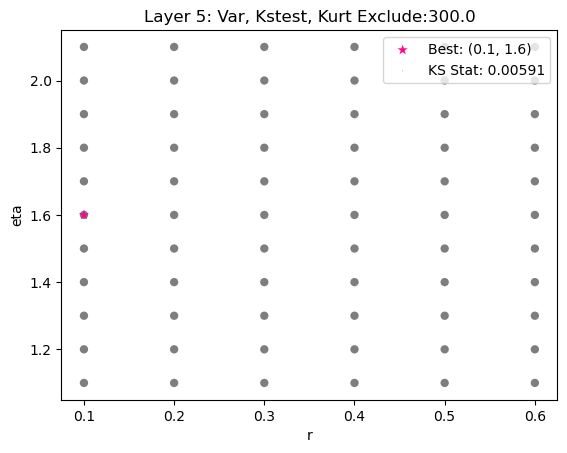

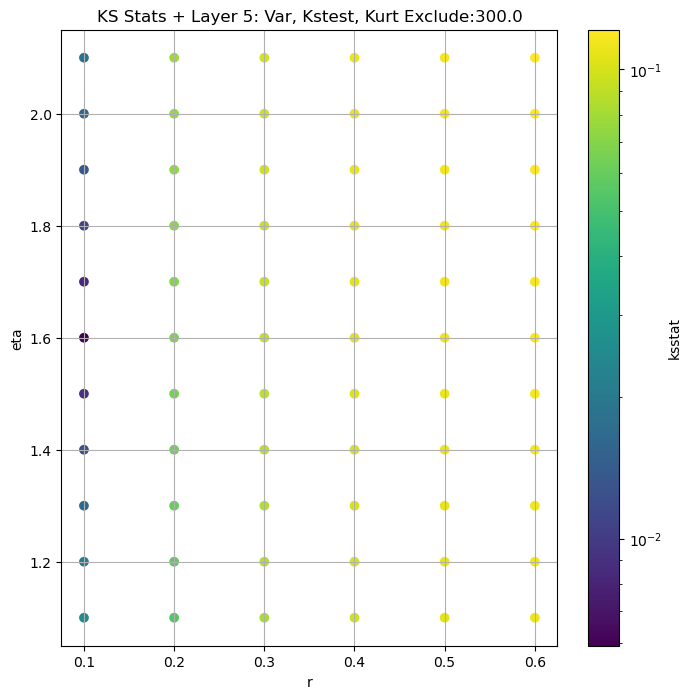

####
Layer  6


100%|██████████| 12760/12760 [00:44<00:00, 285.67it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.03143454203281859 385.11697


100%|██████████| 12760/12760 [00:44<00:00, 284.37it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.019008148129732116 184.44392


100%|██████████| 12760/12760 [00:44<00:00, 285.84it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.014089377874340392 155.67401


100%|██████████| 12760/12760 [00:45<00:00, 280.59it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.011728990284892715 139.58296


100%|██████████| 12760/12760 [00:44<00:00, 285.46it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.010537513067758963 128.89084


100%|██████████| 12760/12760 [00:45<00:00, 278.36it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.00840989403102177 114.92986


100%|██████████| 12760/12760 [00:45<00:00, 282.69it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005971932739331609 105.545555


100%|██████████| 12760/12760 [00:45<00:00, 281.58it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.004299079505978076 98.49664


100%|██████████| 12760/12760 [00:44<00:00, 283.75it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.004817878350866889 92.85376


100%|██████████| 12760/12760 [00:45<00:00, 282.87it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.005444358199807042 88.19705


100%|██████████| 12760/12760 [00:44<00:00, 284.39it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.007079672736670761 77.90948
Number of samples: 100000, Without approximation : 2304000.0


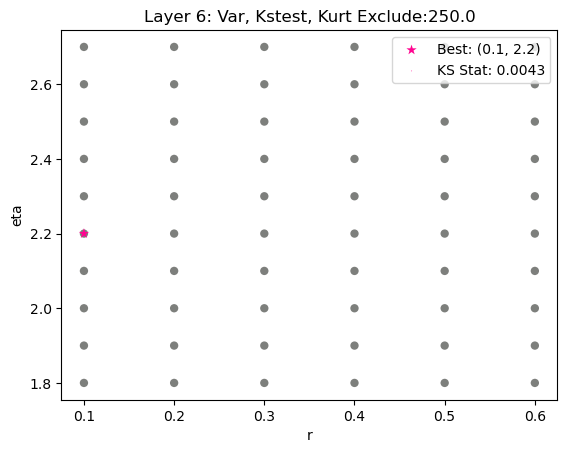

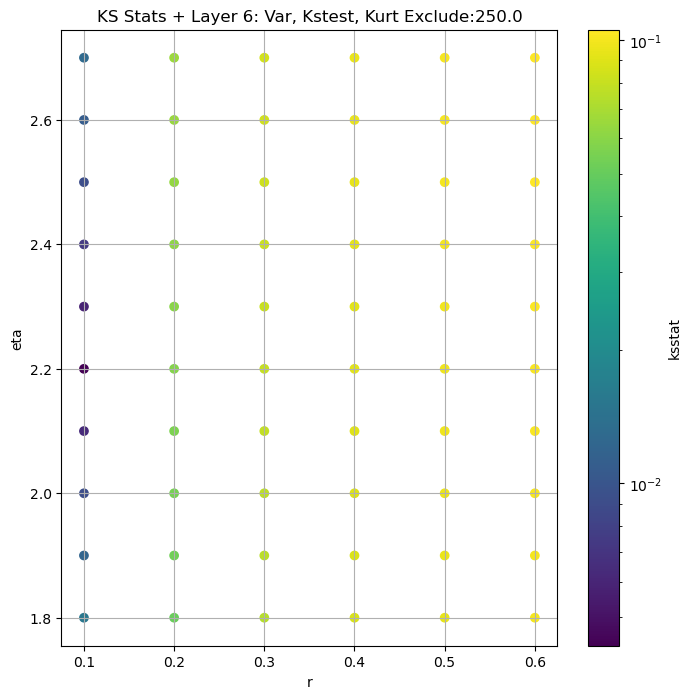

####
Layer  7


100%|██████████| 12760/12760 [00:44<00:00, 285.76it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.03179612620186201 101.06582


100%|██████████| 12760/12760 [00:44<00:00, 286.05it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.012867109441232039 43.042274


100%|██████████| 12760/12760 [00:44<00:00, 285.95it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.009312002575813327 37.106045


100%|██████████| 12760/12760 [00:44<00:00, 286.62it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.006957126688706183 33.80117


100%|██████████| 12760/12760 [00:45<00:00, 283.30it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.0051060714992122724 31.58786


100%|██████████| 12760/12760 [00:44<00:00, 288.09it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.0030675110331882527 28.652582


100%|██████████| 12760/12760 [00:44<00:00, 286.70it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.0030748792329716723 26.685877


100%|██████████| 12760/12760 [00:44<00:00, 283.99it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.0037445414723965564 25.226458


100%|██████████| 12760/12760 [00:44<00:00, 284.43it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.004376539371687138 24.069267


100%|██████████| 12760/12760 [00:45<00:00, 281.29it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.004946973495996154 23.11148


100%|██████████| 12760/12760 [00:45<00:00, 279.27it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.006763000311435785 20.952288
Number of samples: 100000, Without approximation : 9216000.0


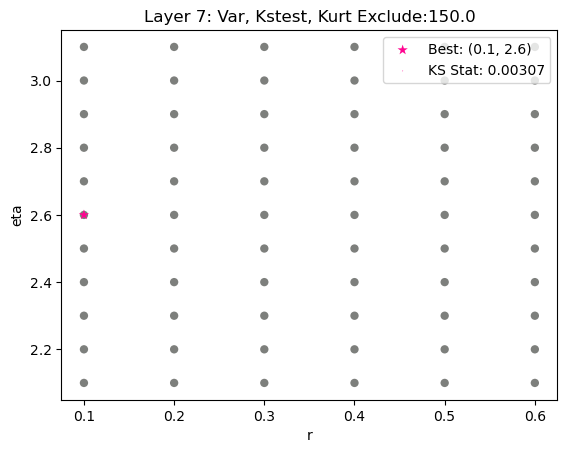

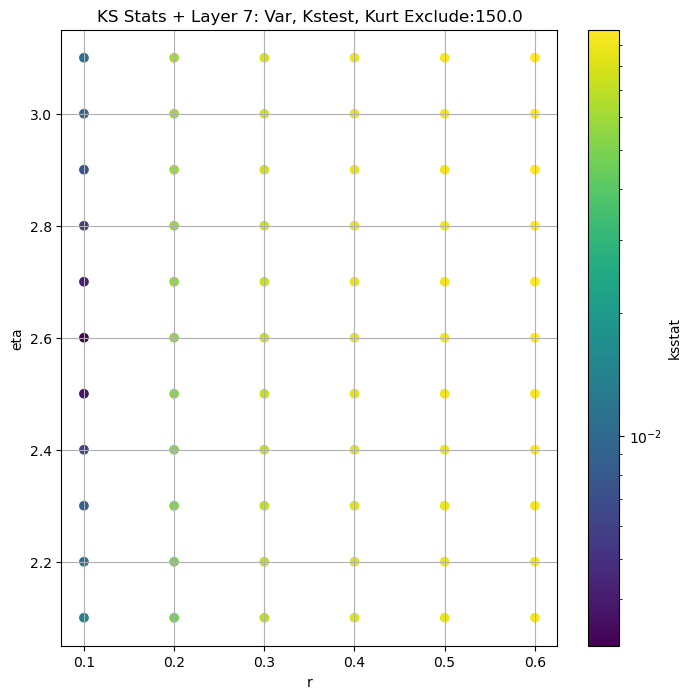

####
Layer  8


100%|██████████| 12760/12760 [00:44<00:00, 285.56it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.02297189833772384 34.40266


100%|██████████| 12760/12760 [00:45<00:00, 281.27it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.009536536144408428 18.636578


100%|██████████| 12760/12760 [00:46<00:00, 275.40it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.006495470026139483 15.866291


100%|██████████| 12760/12760 [00:45<00:00, 279.53it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.0037081651222982404 14.410324


100%|██████████| 12760/12760 [00:46<00:00, 274.11it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.0030299999999999216 13.484938


100%|██████████| 12760/12760 [00:46<00:00, 277.07it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.0030299999999998106 12.334513


100%|██████████| 12760/12760 [00:46<00:00, 276.40it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.0034079852028247037 11.597518


100%|██████████| 12760/12760 [00:45<00:00, 278.22it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.00407202585638089 11.04939


100%|██████████| 12760/12760 [00:46<00:00, 277.08it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.005003638123421306 10.608252


100%|██████████| 12760/12760 [00:45<00:00, 278.30it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.005616738900940055 10.236454


100%|██████████| 12760/12760 [00:45<00:00, 277.59it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007440338120000223 9.369349
Number of samples: 100000, Without approximation : 36864000.0


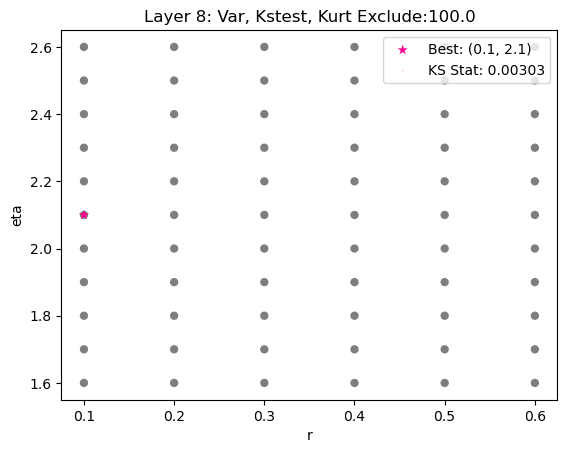

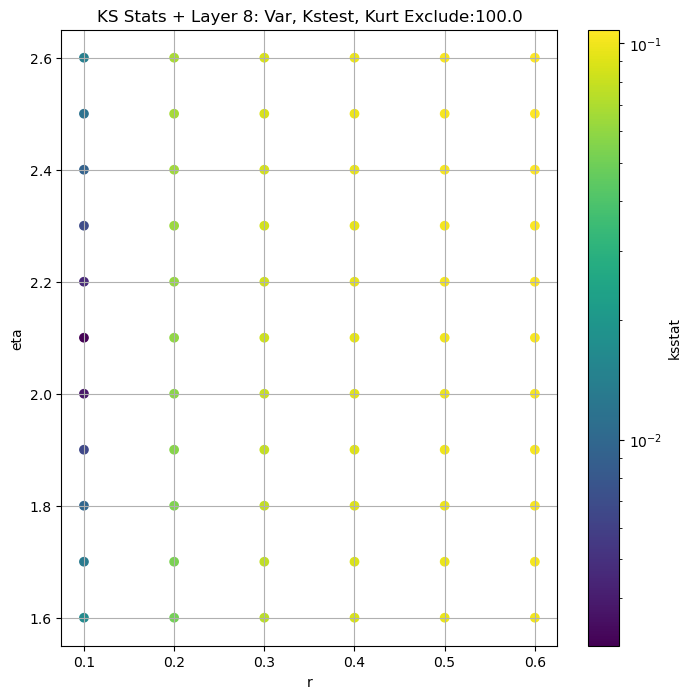

####
Layer  9


100%|██████████| 12760/12760 [00:45<00:00, 277.86it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.02445137988823315 9.889628


100%|██████████| 12760/12760 [00:45<00:00, 278.27it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.013587918315163927 5.496773


100%|██████████| 12760/12760 [00:45<00:00, 280.53it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.00922776663191971 4.6405263


100%|██████████| 12760/12760 [00:46<00:00, 274.52it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.006954815636380229 4.1987376


100%|██████████| 12760/12760 [00:47<00:00, 269.47it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.006830762255369827 3.9225564


100%|██████████| 12760/12760 [00:49<00:00, 258.52it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.005979999999999874 3.5744288


100%|██████████| 12760/12760 [00:49<00:00, 259.18it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.00597999999999993 3.344842


100%|██████████| 12760/12760 [00:51<00:00, 248.05it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.005979999999990548 3.1710358


100%|██████████| 12760/12760 [00:51<00:00, 249.43it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.005979999999990826 3.029906


100%|██████████| 12760/12760 [00:53<00:00, 239.79it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.00615287314374402 2.910432


100%|██████████| 12760/12760 [00:53<00:00, 240.02it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.0079536491273281 2.6311245
Number of samples: 100000, Without approximation : 147456000.0


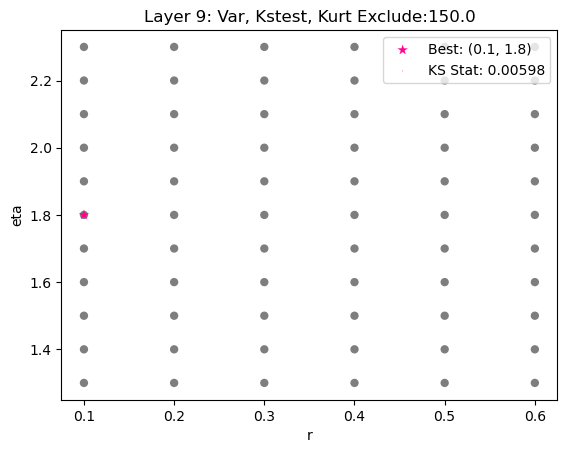

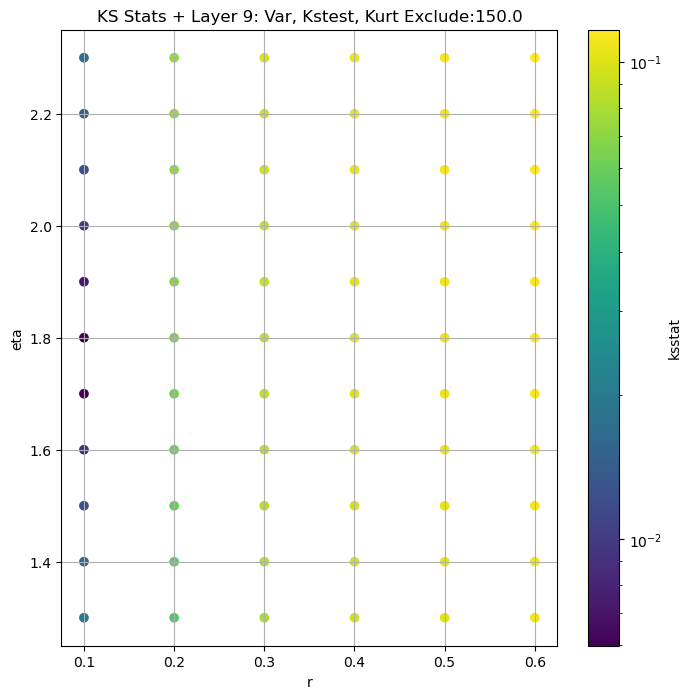

####
Layer  10


100%|██████████| 12760/12760 [00:54<00:00, 232.97it/s]


Finding Minimum after computing 12760 CDFs
10 0 0.028484671741772383 1.4365472


100%|██████████| 12760/12760 [01:02<00:00, 203.88it/s]


Finding Minimum after computing 12760 CDFs
10 25 0.02517999999998688 0.74990654


100%|██████████| 12760/12760 [00:55<00:00, 229.75it/s]


Finding Minimum after computing 12760 CDFs
10 50 0.025179999999989766 0.6381468


100%|██████████| 12760/12760 [00:53<00:00, 237.45it/s]


Finding Minimum after computing 12760 CDFs
10 75 0.0251799999999891 0.57833797


100%|██████████| 12760/12760 [00:54<00:00, 235.05it/s]


Finding Minimum after computing 12760 CDFs
10 100 0.025179999999988767 0.5394436


100%|██████████| 12760/12760 [00:51<00:00, 245.63it/s]


Finding Minimum after computing 12760 CDFs
10 150 0.025179999999987324 0.48890162


100%|██████████| 12760/12760 [00:54<00:00, 235.38it/s]


Finding Minimum after computing 12760 CDFs
10 200 0.02517999999998355 0.45518756


100%|██████████| 12760/12760 [00:54<00:00, 236.08it/s]


Finding Minimum after computing 12760 CDFs
10 250 0.025179999999982994 0.42966205


100%|██████████| 12760/12760 [00:57<00:00, 222.51it/s]


Finding Minimum after computing 12760 CDFs
10 300 0.025179999999982217 0.40904057


100%|██████████| 12760/12760 [01:04<00:00, 198.81it/s]


Finding Minimum after computing 12760 CDFs
10 350 0.025179999999981773 0.39167765


100%|██████████| 12760/12760 [00:58<00:00, 217.50it/s]


Finding Minimum after computing 12760 CDFs
10 500 0.025179999999980773 0.3512307
Number of samples: 100000, Without approximation : 589824000.0


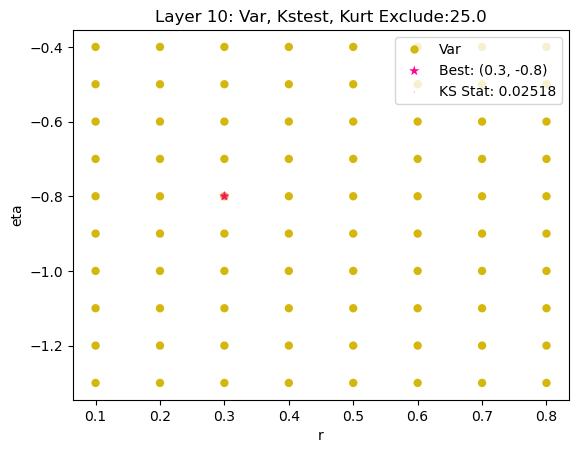

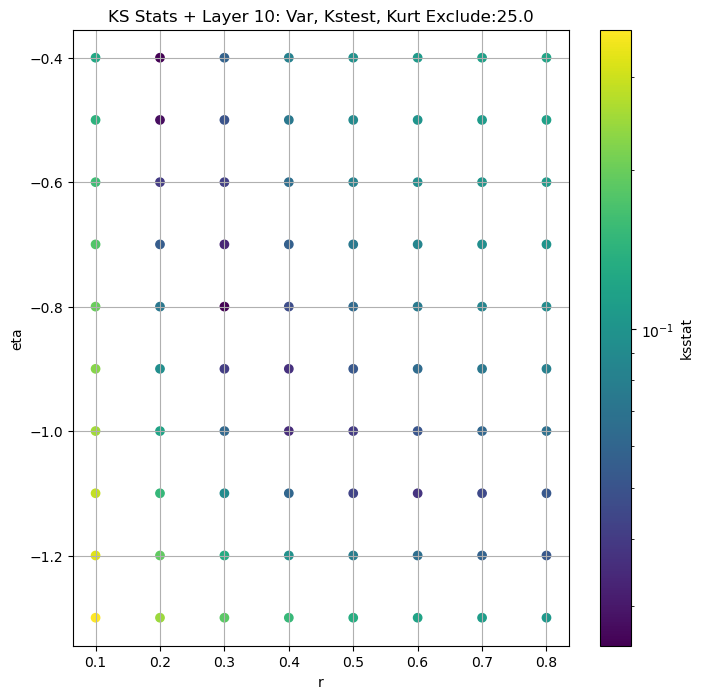

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2      181300.620000  101526.980000  290784.600000   377.25858  142.297880   
3       38789.977000   21575.424000   67721.520000   543.33215  122.402770   
4        9777.212000    4939.198000   17950.002000   703.37980  122.038475   
5        1796.315800     838.102050    4289.250000  1421.50900   90.012470   
6         385.116970     175.524030    1132.752800  2320.62400   86.752716   
7         101.065820      41.339350     424.445160  4759.82570   66.990580   
8          34.402660      17.916046      89.423820  1601.38330   74.529690   
9           9.889628       5.271114      25.139076  1503.44800   80.922005   
10          1.436547       0.712656       4.498758  2683.97460   76.523470   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       530.93066         9000.0             0.013746        0.1          2.7   
3      1044.48300        36000.0             0.009030        0.1          1.8   
4      1327.72410       144000.0             0.006965        0.1          1.4   
5      3420.72660       576000.0             0.005912        0.1          1.6   
6      4403.35350      2304000.0             0.004299        0.1          2.2   
7      6336.49370      9216000.0             0.003068        0.1          2.6   
8      3574.43000     36864000.0             0.003030        0.1          2.1   
9      3413.64060    147456000.0             0.005980        0.1          1.8   
10     4568.20360    589824000.0             0.025180        0.3         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       9.706194e-13                    50.0        45005.450000   
3       1.877390e-12                   150.0        10024.462000   
4       1.271697e-12                   350.0         2181.540300   
5       1.396978e-13                   300.0          429.708980   
6       6.658661e-15                   250.0           98.496640   
7       7.686594e-16                   150.0           28.652582   
8       1.164849e-15                   100.0           13.484938   
9       6.694223e-16                   150.0            3.574429   
10      1.300548e-02                    25.0            0.749907   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [14]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [15]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 522/522 [00:00<00:00, 998.82it/s] 


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 100 = 150, ksstat: 0.024536631367757786, var: 29935.513671875


100%|██████████| 522/522 [00:00<00:00, 2320.63it/s]


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 75 = 125, ksstat: 0.02167728877948849, var: 32620.91796875


100%|██████████| 522/522 [00:00<00:00, 2505.42it/s]


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 50 = 100, ksstat: 0.018723282471199296, var: 35826.734375


100%|██████████| 522/522 [00:00<00:00, 2301.76it/s]


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 25 = 75, ksstat: 0.0157188069734277, var: 39764.796875


100%|██████████| 522/522 [00:00<00:00, 2466.49it/s]


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 0 = 50, ksstat: 0.013746479136173329, var: 45005.44921875


100%|██████████| 522/522 [00:00<00:00, 2656.78it/s]


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + -25 = 25, ksstat: 0.013815792407346872, var: 53445.76171875


100%|██████████| 522/522 [00:00<00:00, 2748.63it/s]


Finding Minimum after computing 522 CDFs
layer 2, 50.0 + -50 = 0, ksstat: 0.025843857612806165, var: 181300.625
Number of samples: 9000, Without approximation : 9000.0


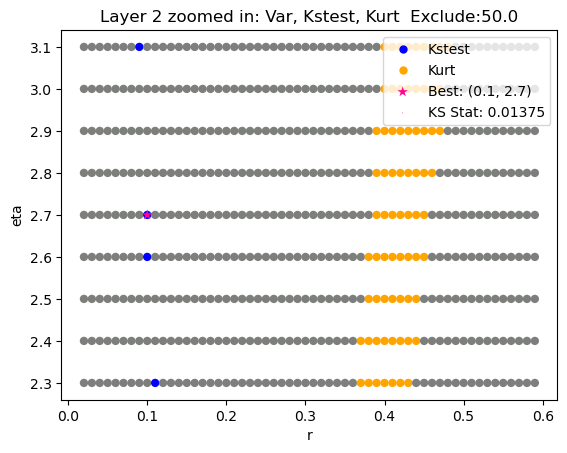

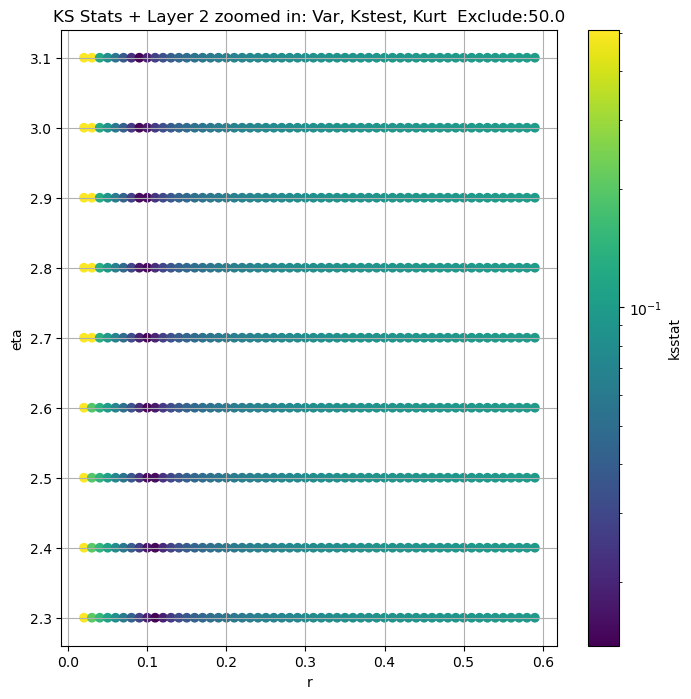

Layer 3


100%|██████████| 580/580 [00:01<00:00, 498.16it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 100 = 250, ksstat: 0.01256933738972683, var: 8276.5087890625


100%|██████████| 580/580 [00:00<00:00, 703.15it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 75 = 225, ksstat: 0.011748126428637724, var: 8636.048828125


100%|██████████| 580/580 [00:00<00:00, 715.17it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 50 = 200, ksstat: 0.010710757349672976, var: 9036.4814453125


100%|██████████| 580/580 [00:00<00:00, 690.39it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 25 = 175, ksstat: 0.009754725552852457, var: 9488.859375


100%|██████████| 580/580 [00:00<00:00, 602.20it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 0 = 150, ksstat: 0.009030392608931348, var: 10024.4619140625


100%|██████████| 580/580 [00:00<00:00, 685.19it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -25 = 125, ksstat: 0.008750612450706075, var: 10664.005859375


100%|██████████| 580/580 [00:00<00:00, 705.31it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -50 = 100, ksstat: 0.009090205287358266, var: 11435.9365234375


100%|██████████| 580/580 [00:00<00:00, 738.66it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -75 = 75, ksstat: 0.009559196964629146, var: 12451.0029296875


100%|██████████| 580/580 [00:00<00:00, 677.32it/s]


Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -100 = 50, ksstat: 0.010742253943532676, var: 13901.5419921875
Number of samples: 36000, Without approximation : 36000.0


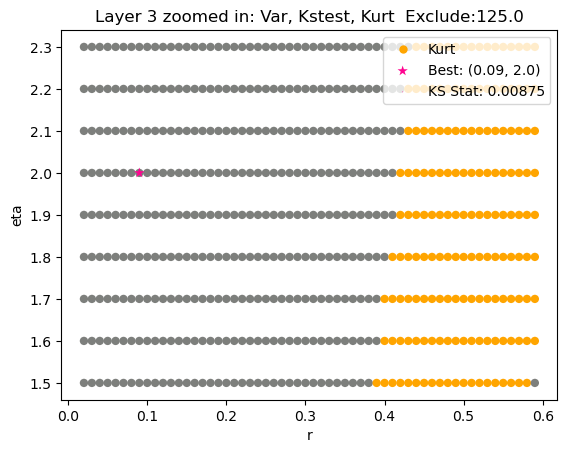

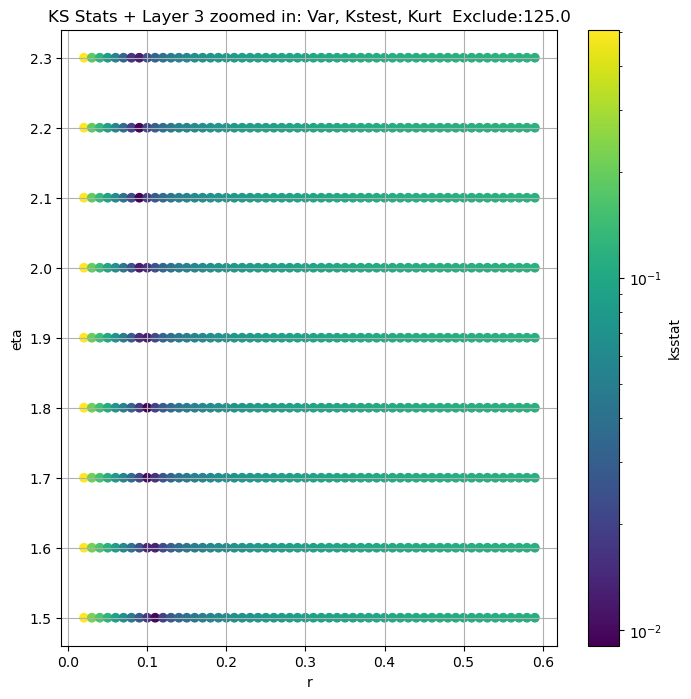

Layer 4


100%|██████████| 580/580 [00:02<00:00, 213.43it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 100 = 450, ksstat: 0.008021963876705174, var: 1974.6051025390625


100%|██████████| 580/580 [00:02<00:00, 235.43it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 75 = 425, ksstat: 0.007682781300286136, var: 2021.6015625


100%|██████████| 580/580 [00:02<00:00, 242.76it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 50 = 400, ksstat: 0.007261880681055856, var: 2071.406982421875


100%|██████████| 580/580 [00:02<00:00, 237.04it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 25 = 375, ksstat: 0.006935938422753418, var: 2124.4404296875


100%|██████████| 580/580 [00:02<00:00, 243.13it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 0 = 350, ksstat: 0.006964605775686472, var: 2181.540283203125


100%|██████████| 580/580 [00:02<00:00, 247.44it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -25 = 325, ksstat: 0.0067413836060266075, var: 2243.481201171875


100%|██████████| 580/580 [00:02<00:00, 248.25it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -50 = 300, ksstat: 0.007627841040872441, var: 2312.419189453125


100%|██████████| 580/580 [00:02<00:00, 230.25it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -75 = 275, ksstat: 0.007974212581742246, var: 2388.11279296875


100%|██████████| 580/580 [00:02<00:00, 219.54it/s]


Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -100 = 250, ksstat: 0.008456966066704541, var: 2475.11181640625
Number of samples: 100000, Without approximation : 144000.0


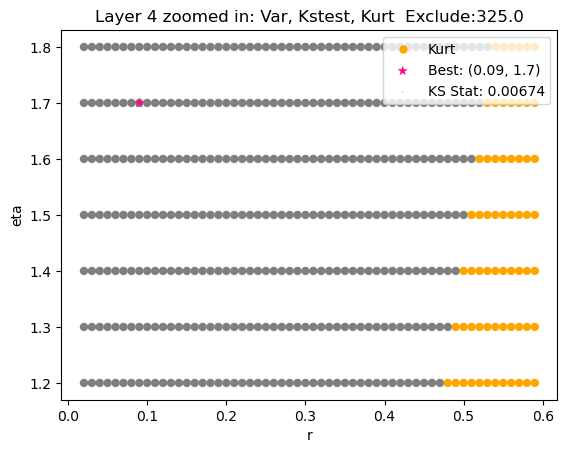

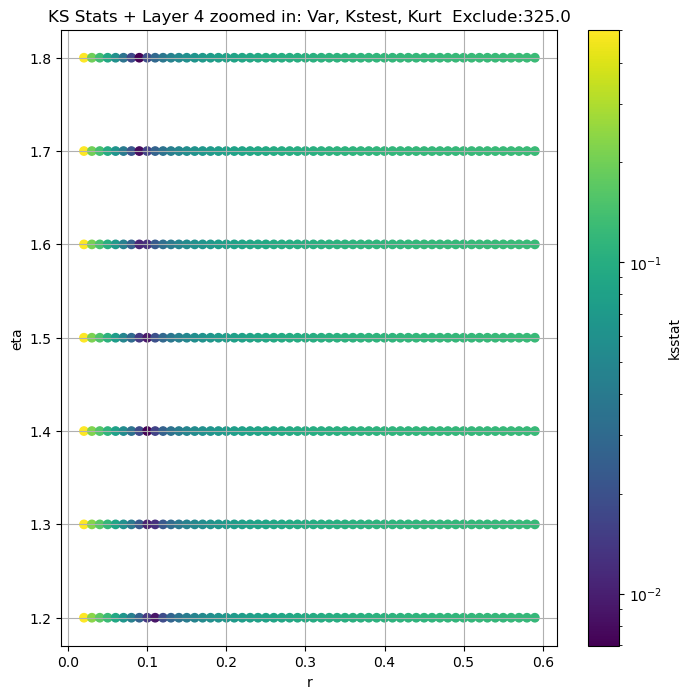

Layer 5


100%|██████████| 522/522 [00:02<00:00, 206.00it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 100 = 400, ksstat: 0.006840396898591283, var: 386.393798828125


100%|██████████| 522/522 [00:02<00:00, 176.77it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 75 = 375, ksstat: 0.006445844608936824, var: 395.9632873535156


100%|██████████| 522/522 [00:02<00:00, 189.80it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 50 = 350, ksstat: 0.006110049726806066, var: 406.2822265625


100%|██████████| 522/522 [00:02<00:00, 212.96it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 25 = 325, ksstat: 0.005922395122458957, var: 417.4905700683594


100%|██████████| 522/522 [00:02<00:00, 225.72it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 0 = 300, ksstat: 0.005912303286083165, var: 429.708984375


100%|██████████| 522/522 [00:02<00:00, 240.65it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -25 = 275, ksstat: 0.006236027054904558, var: 443.1042785644531


100%|██████████| 522/522 [00:02<00:00, 236.33it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -50 = 250, ksstat: 0.006750952001484678, var: 457.912841796875


100%|██████████| 522/522 [00:02<00:00, 234.72it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -75 = 225, ksstat: 0.008010878353992945, var: 474.40216064453125


100%|██████████| 522/522 [00:02<00:00, 240.91it/s]


Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -100 = 200, ksstat: 0.008431186285178416, var: 493.0188903808594
Number of samples: 100000, Without approximation : 576000.0


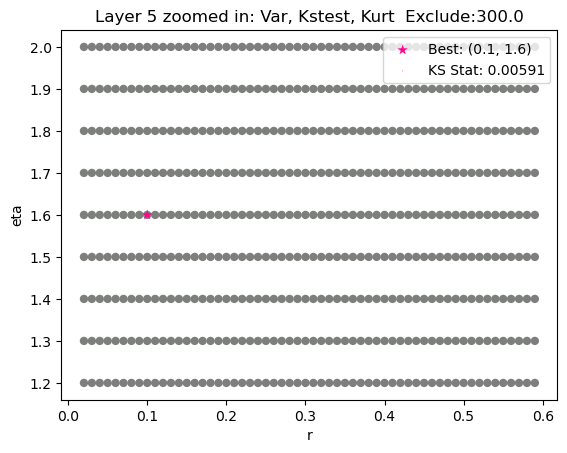

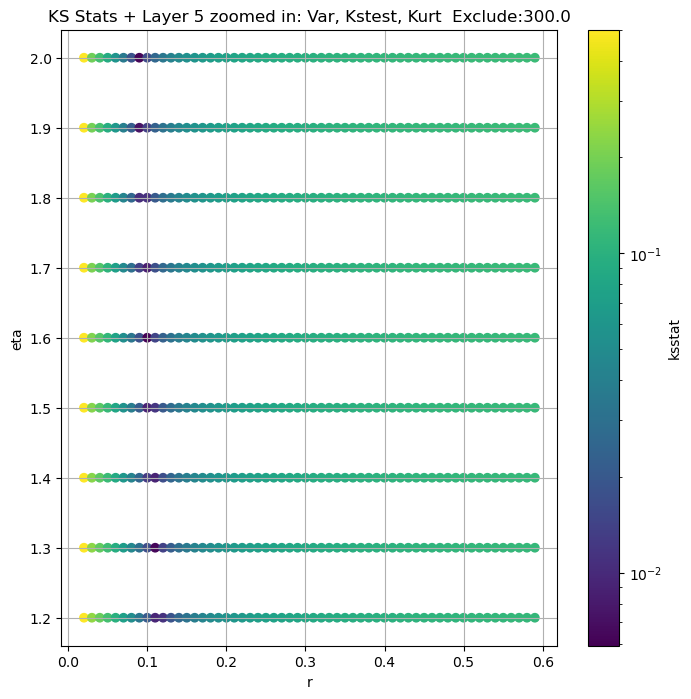

Layer 6


100%|██████████| 522/522 [00:02<00:00, 222.89it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.005408154763723028, var: 88.19705200195312


100%|██████████| 522/522 [00:02<00:00, 243.14it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.005074133483818022, var: 90.42005157470703


100%|██████████| 522/522 [00:02<00:00, 220.34it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.004793434282366227, var: 92.853759765625


100%|██████████| 522/522 [00:02<00:00, 214.97it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.004436314005498043, var: 95.53330993652344


100%|██████████| 522/522 [00:02<00:00, 200.02it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.004299079505978076, var: 98.49664306640625


100%|██████████| 522/522 [00:02<00:00, 229.15it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.004704462657462827, var: 101.79881286621094


100%|██████████| 522/522 [00:02<00:00, 207.98it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.005430482930141478, var: 105.5455551147461


100%|██████████| 522/522 [00:02<00:00, 175.75it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.006677872019873465, var: 109.86759948730469


100%|██████████| 522/522 [00:03<00:00, 146.27it/s]


Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.007166897863029709, var: 114.92986297607422
Number of samples: 100000, Without approximation : 2304000.0


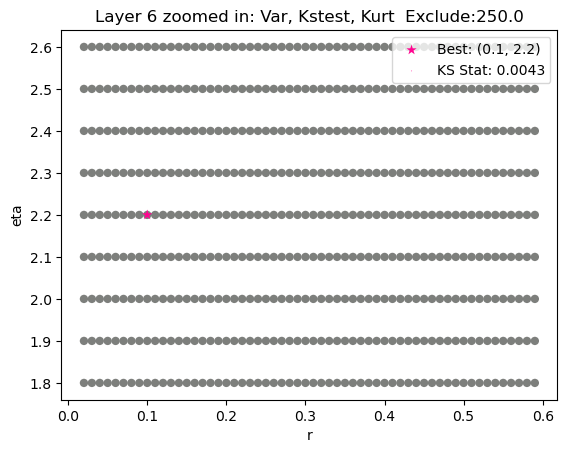

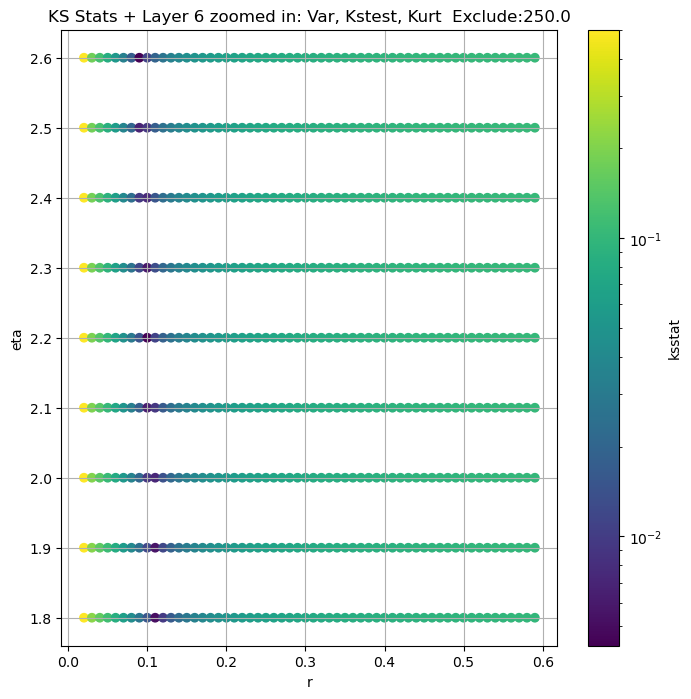

Layer 7


100%|██████████| 522/522 [00:02<00:00, 184.98it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.003704569071472874, var: 25.226457595825195


100%|██████████| 522/522 [00:02<00:00, 184.77it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.003396167834394337, var: 25.90897560119629


100%|██████████| 522/522 [00:02<00:00, 194.17it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.0030748792329716723, var: 26.685876846313477


100%|██████████| 522/522 [00:02<00:00, 187.64it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.002767474944029402, var: 27.586118698120117


100%|██████████| 522/522 [00:02<00:00, 202.63it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.002949627840197755, var: 28.6525821685791


100%|██████████| 522/522 [00:02<00:00, 201.67it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0038930641064448546, var: 29.94985008239746


100%|██████████| 522/522 [00:02<00:00, 206.01it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.0051060714992122724, var: 31.587860107421875


100%|██████████| 522/522 [00:02<00:00, 207.29it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.006317225050372355, var: 33.801170349121094


100%|██████████| 522/522 [00:02<00:00, 201.31it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.00849944531696345, var: 37.10604476928711
Number of samples: 100000, Without approximation : 9216000.0


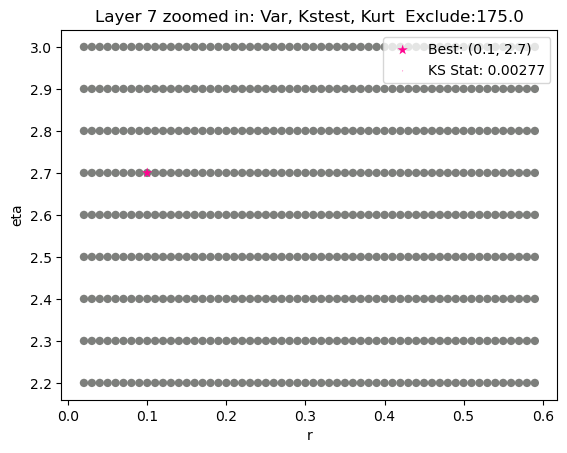

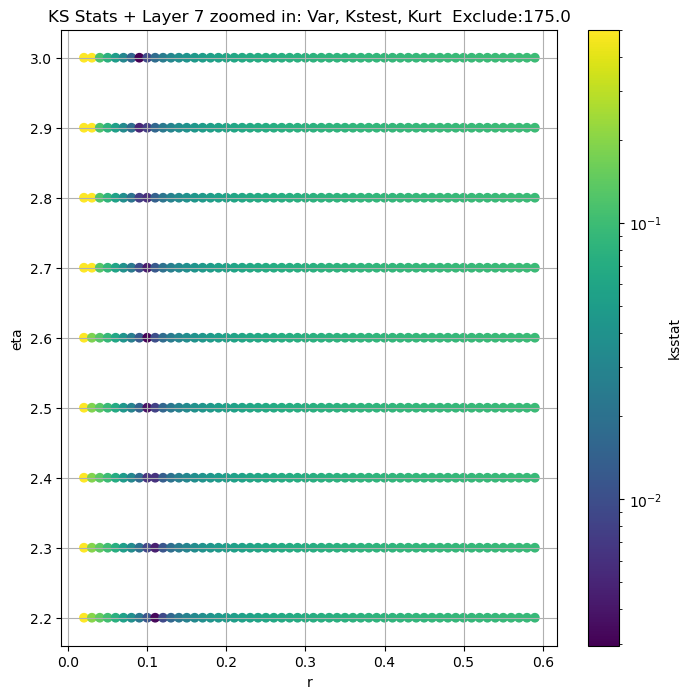

Layer 8


100%|██████████| 522/522 [00:02<00:00, 177.53it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 100 = 200, ksstat: 0.0038764898632938083, var: 11.597517967224121


100%|██████████| 522/522 [00:02<00:00, 213.71it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 75 = 175, ksstat: 0.0032412212597447976, var: 11.933999061584473


100%|██████████| 522/522 [00:02<00:00, 203.47it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 50 = 150, ksstat: 0.0030299999999965355, var: 12.334512710571289


100%|██████████| 522/522 [00:02<00:00, 203.54it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 25 = 125, ksstat: 0.003029999999999755, var: 12.831364631652832


100%|██████████| 522/522 [00:02<00:00, 198.11it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 0 = 100, ksstat: 0.003029999999999755, var: 13.48493766784668


100%|██████████| 522/522 [00:02<00:00, 203.74it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -25 = 75, ksstat: 0.0033163505283975575, var: 14.410324096679688


100%|██████████| 522/522 [00:02<00:00, 203.20it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -50 = 50, ksstat: 0.005150103401108039, var: 15.866291046142578


100%|██████████| 522/522 [00:02<00:00, 196.05it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -75 = 25, ksstat: 0.009286142275459458, var: 18.636577606201172


100%|██████████| 522/522 [00:02<00:00, 194.16it/s]


Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -100 = 0, ksstat: 0.020231569324513456, var: 34.40266036987305
Number of samples: 100000, Without approximation : 36864000.0


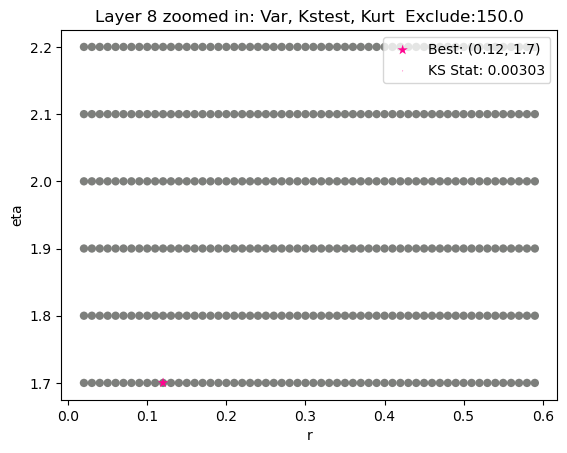

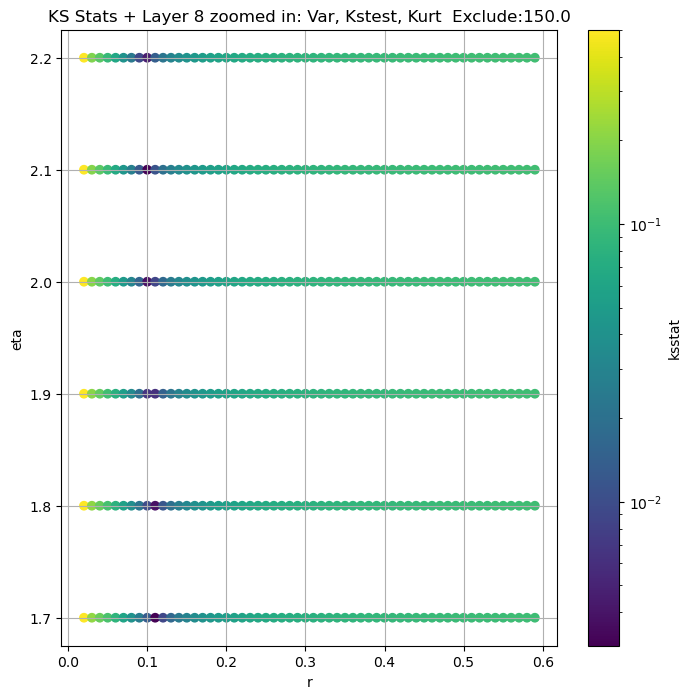

Layer 9


100%|██████████| 580/580 [00:03<00:00, 175.53it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 100 = 250, ksstat: 0.005979999999982444, var: 3.1710357666015625


100%|██████████| 580/580 [00:02<00:00, 236.21it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 75 = 225, ksstat: 0.005979999999982666, var: 3.2528560161590576


100%|██████████| 580/580 [00:02<00:00, 241.82it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 50 = 200, ksstat: 0.005979999999982888, var: 3.344841957092285


100%|██████████| 580/580 [00:02<00:00, 246.22it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 25 = 175, ksstat: 0.0059799999999957665, var: 3.450274705886841


100%|██████████| 580/580 [00:02<00:00, 243.93it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 0 = 150, ksstat: 0.005979999999994046, var: 3.5744287967681885


100%|██████████| 580/580 [00:02<00:00, 246.49it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -25 = 125, ksstat: 0.005979999999999819, var: 3.726269006729126


100%|██████████| 580/580 [00:02<00:00, 237.81it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -50 = 100, ksstat: 0.00597999999999993, var: 3.9225564002990723


100%|██████████| 580/580 [00:02<00:00, 236.91it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -75 = 75, ksstat: 0.006382137743509472, var: 4.198737621307373


100%|██████████| 580/580 [00:02<00:00, 229.56it/s]


Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -100 = 50, ksstat: 0.00905131938381841, var: 4.640526294708252
Number of samples: 100000, Without approximation : 147456000.0


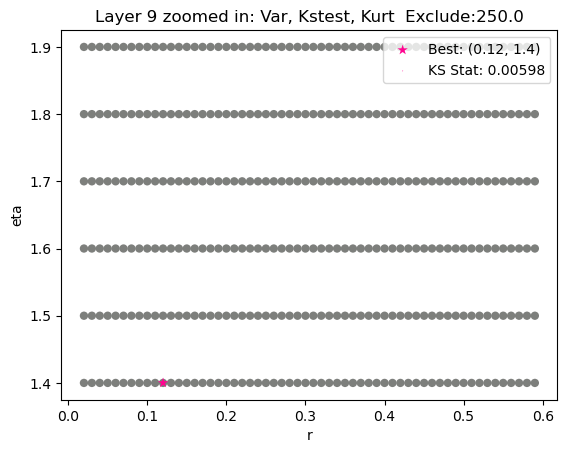

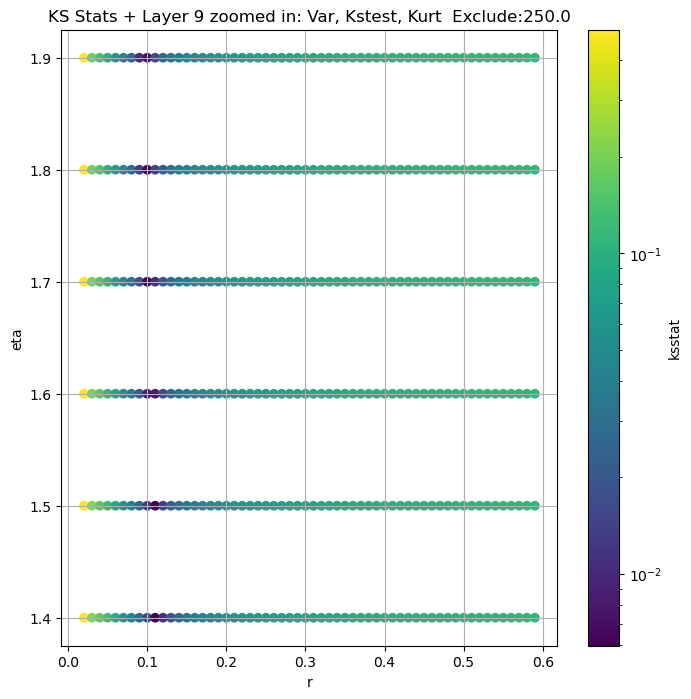

Layer 10


100%|██████████| 1332/1332 [00:06<00:00, 204.94it/s]


Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 100 = 125, ksstat: 0.025179999999979774, var: 0.5111279487609863


100%|██████████| 1332/1332 [00:05<00:00, 237.33it/s]


Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 75 = 100, ksstat: 0.025179999999983882, var: 0.5394436120986938


100%|██████████| 1332/1332 [00:05<00:00, 236.76it/s]


Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 50 = 75, ksstat: 0.025179999999984548, var: 0.5783379673957825


100%|██████████| 1332/1332 [00:05<00:00, 226.48it/s]


Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 25 = 50, ksstat: 0.025179999999984215, var: 0.6381468176841736


100%|██████████| 1332/1332 [00:05<00:00, 237.26it/s]


Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + 0 = 25, ksstat: 0.02517999999998688, var: 0.7499065399169922


100%|██████████| 1332/1332 [00:05<00:00, 245.42it/s]


Finding Minimum after computing 1332 CDFs
layer 10, 25.0 + -25 = 0, ksstat: 0.032388871517353535, var: 1.4365471601486206
Number of samples: 100000, Without approximation : 589824000.0


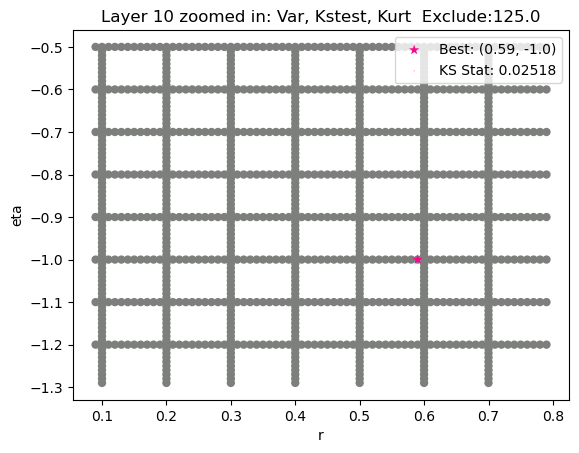

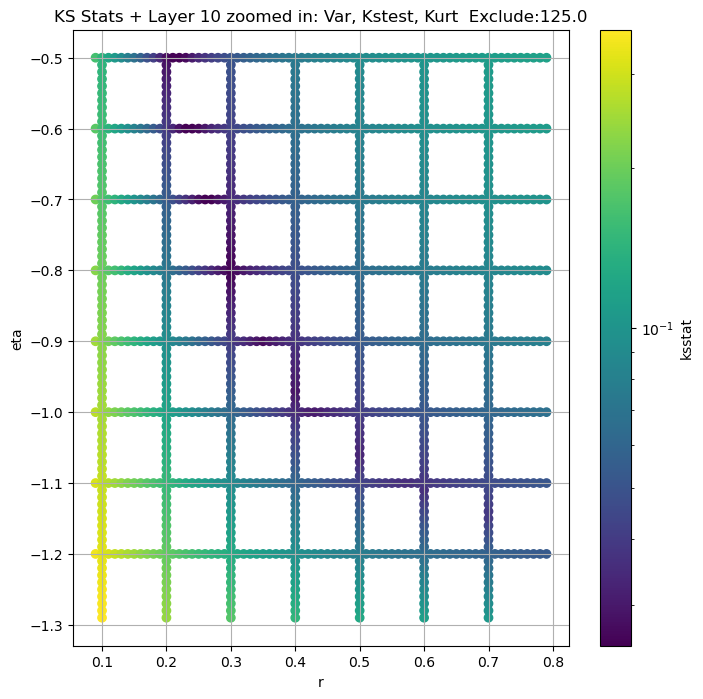

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2      181300.620000  101526.980000  290784.600000   377.25858  142.297880   
3       38789.977000   21575.424000   67721.520000   543.33215  122.402770   
4        9777.212000    4939.198000   17950.002000   703.37980  122.038475   
5        1796.315800     838.102050    4289.250000  1421.50900   90.012470   
6         385.116970     175.524030    1132.752800  2320.62400   86.752716   
7         101.065820      41.339350     424.445160  4759.82570   66.990580   
8          34.402660      17.916046      89.423820  1601.38330   74.529690   
9           9.889628       5.271114      25.139076  1503.44800   80.922005   
10          1.436547       0.712656       4.498758  2683.97460   76.523470   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       530.93066         9000.0             0.013746        0.1          2.7   
3      1044.48300        36000.0             0.009030        0.1          1.8   
4      1327.72410       144000.0             0.006965        0.1          1.4   
5      3420.72660       576000.0             0.005912        0.1          1.6   
6      4403.35350      2304000.0             0.004299        0.1          2.2   
7      6336.49370      9216000.0             0.003068        0.1          2.6   
8      3574.43000     36864000.0             0.003030        0.1          2.1   
9      3413.64060    147456000.0             0.005980        0.1          1.8   
10     4568.20360    589824000.0             0.025180        0.3         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       9.706194e-13                    50.0        45005.450000   
3       1.877390e-12                   150.0        10664.005859   
4       1.271697e-12                   350.0         2243.481201   
5       1.396978e-13                   300.0          429.708980   
6       6.658661e-15                   250.0           98.496640   
7       7.686594e-16                   150.0           27.586119   
8       1.164849e-15                   100.0           12.334513   
9       6.694223e-16                   150.0            3.171036   
10      1.300548e-02                    25.0            0.511128   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.013746    0.10       2.7   
3                     0.007153          0.008751    0.09       2.0   
4                     0.003578          0.006741    0.09       1.7   
5                     0.001789          0.005912    0.10       1.6   
6                     0.000895          0.004299    0.10       2.2   
7                     0.000447          0.002767    0.10       2.7   
8                     0.000224          0.003030    0.12       1.7   
9                     0.000112          0.005980    0.12       1.4   
10                    0.000056          0.025180    0.59      -1.0   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      9.706194e-13                 50.0        10125  
3      6.112826e-15                125.0        24322  
4      3.105290e-15                325.0        40500  
5      1.396978e-13                300.0        54000  
6      6.658661e-15                250.0       102514  
7      5.949418e-16                175.0       243000  
8      5.663263e-12                150.0       205030  
9      2.996181e-12                250.0        54000  
10     4.159152e-01                125.0         2845

In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

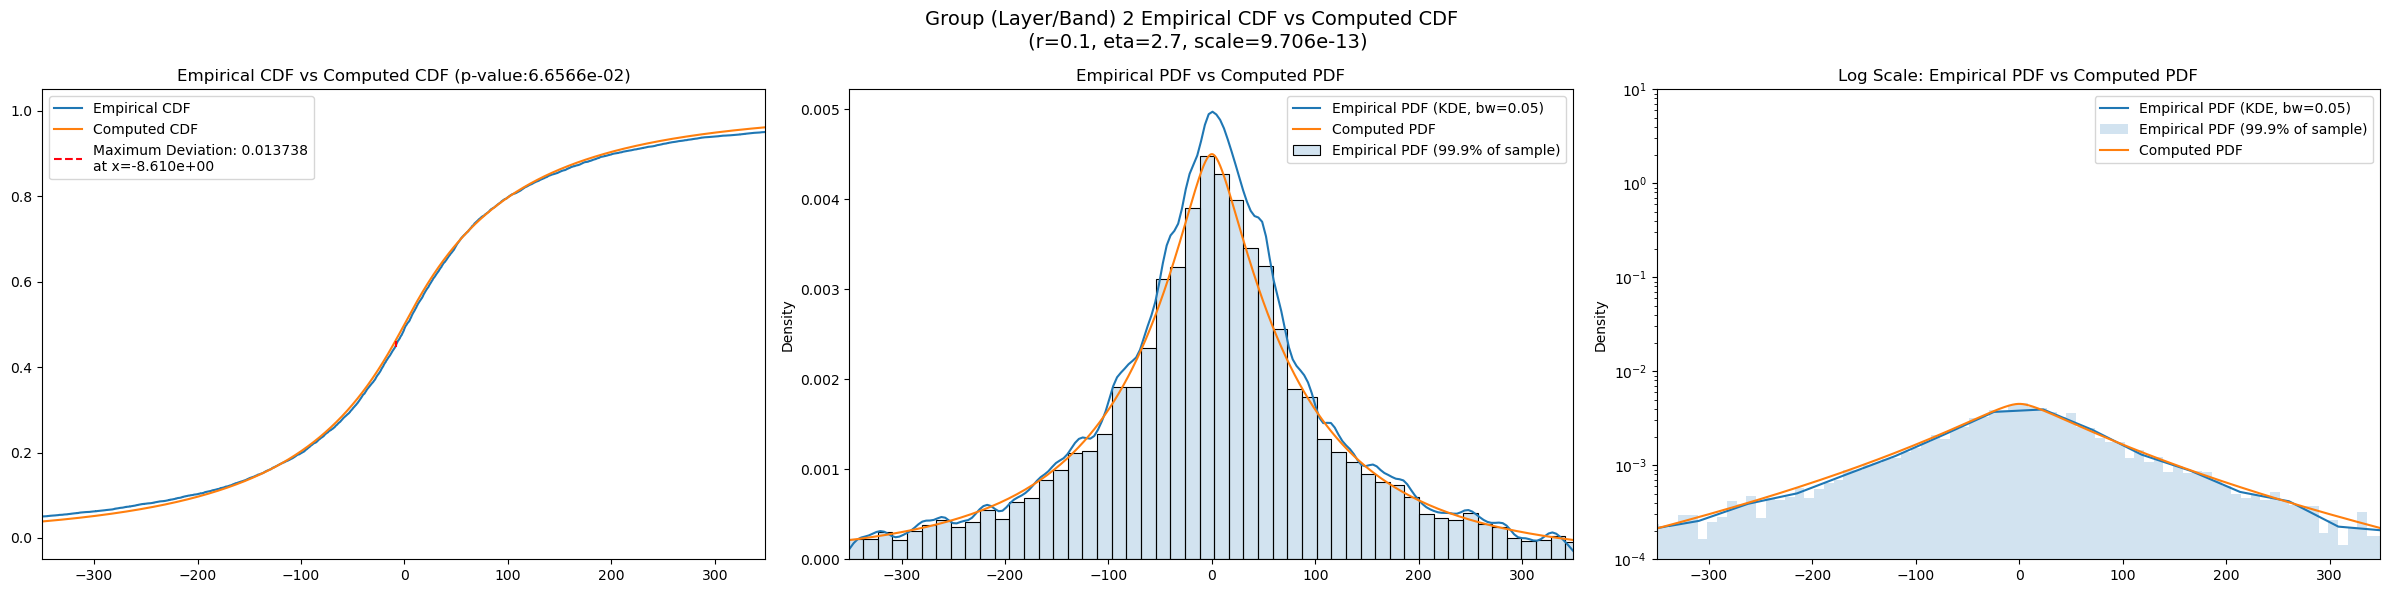

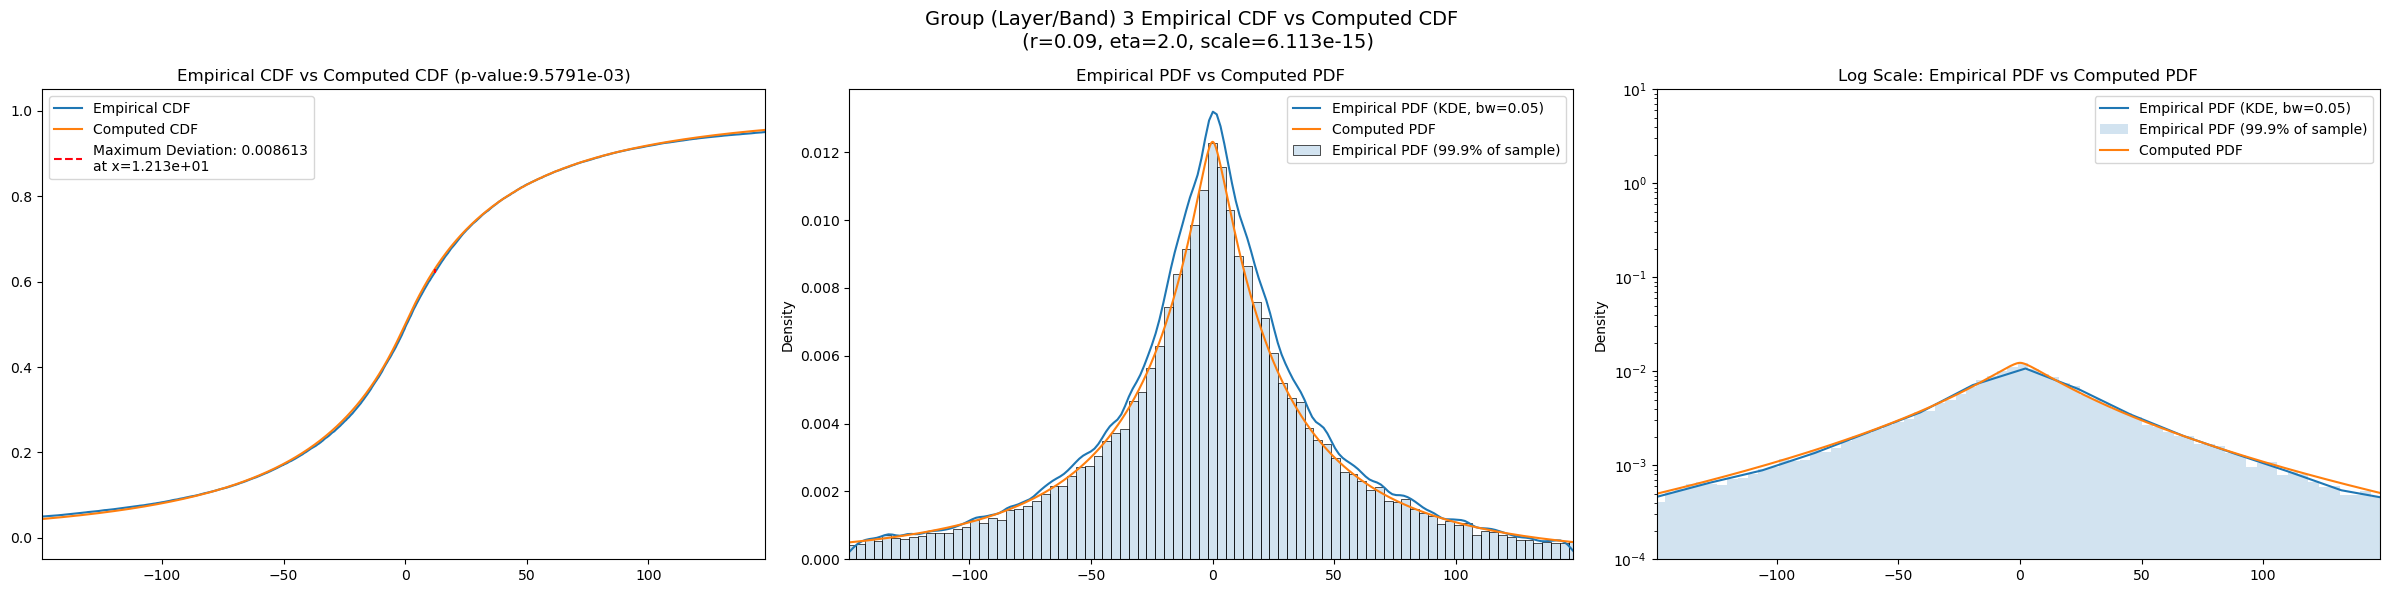

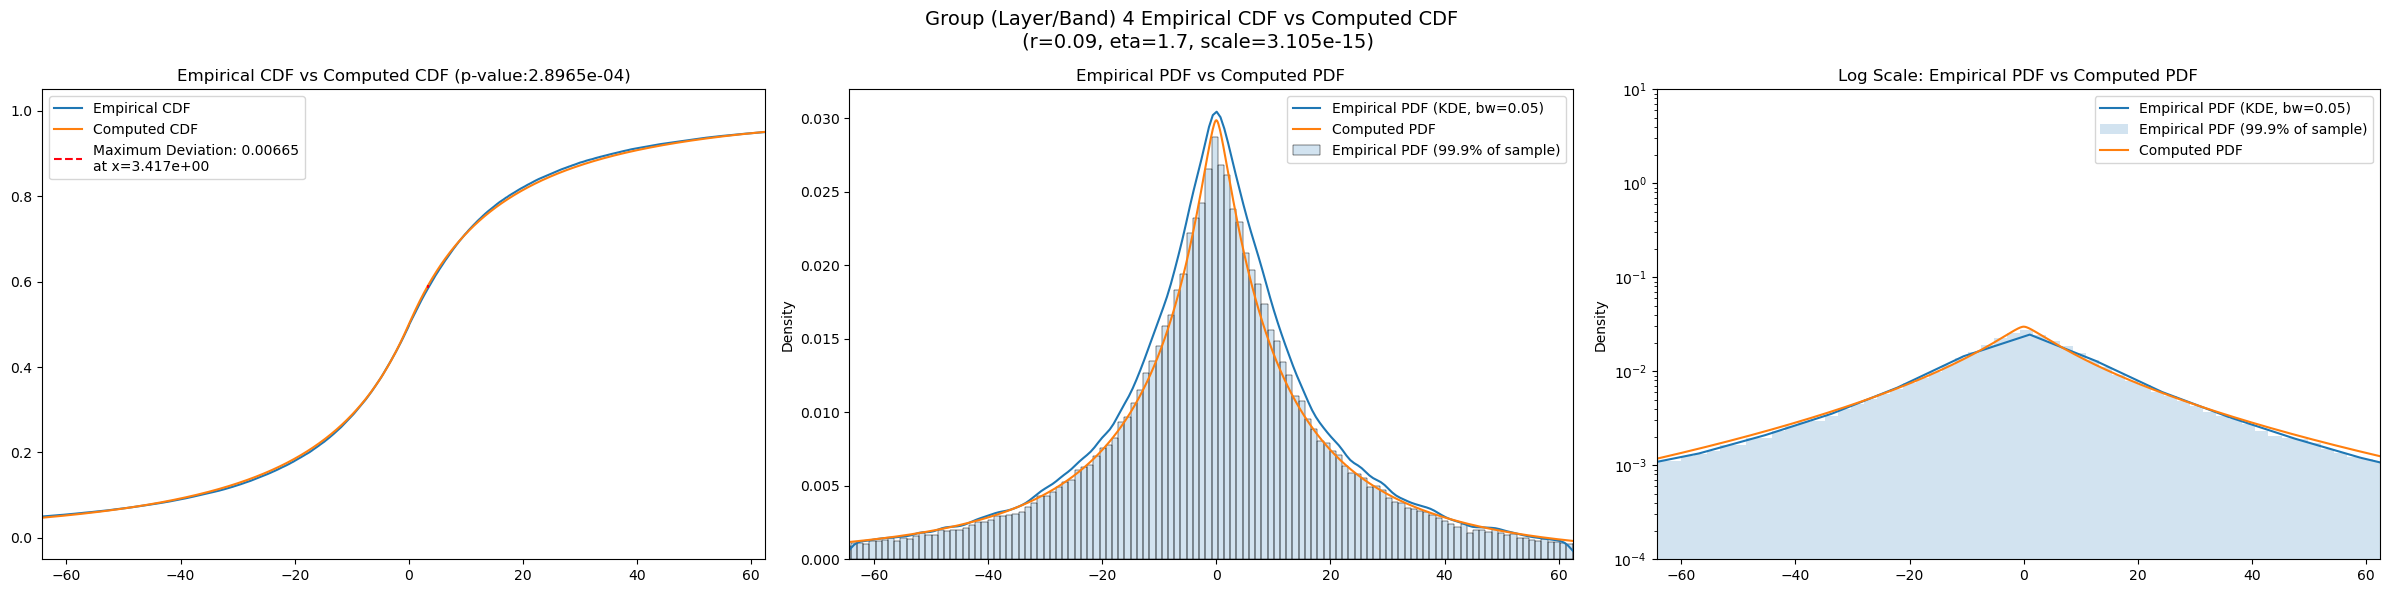

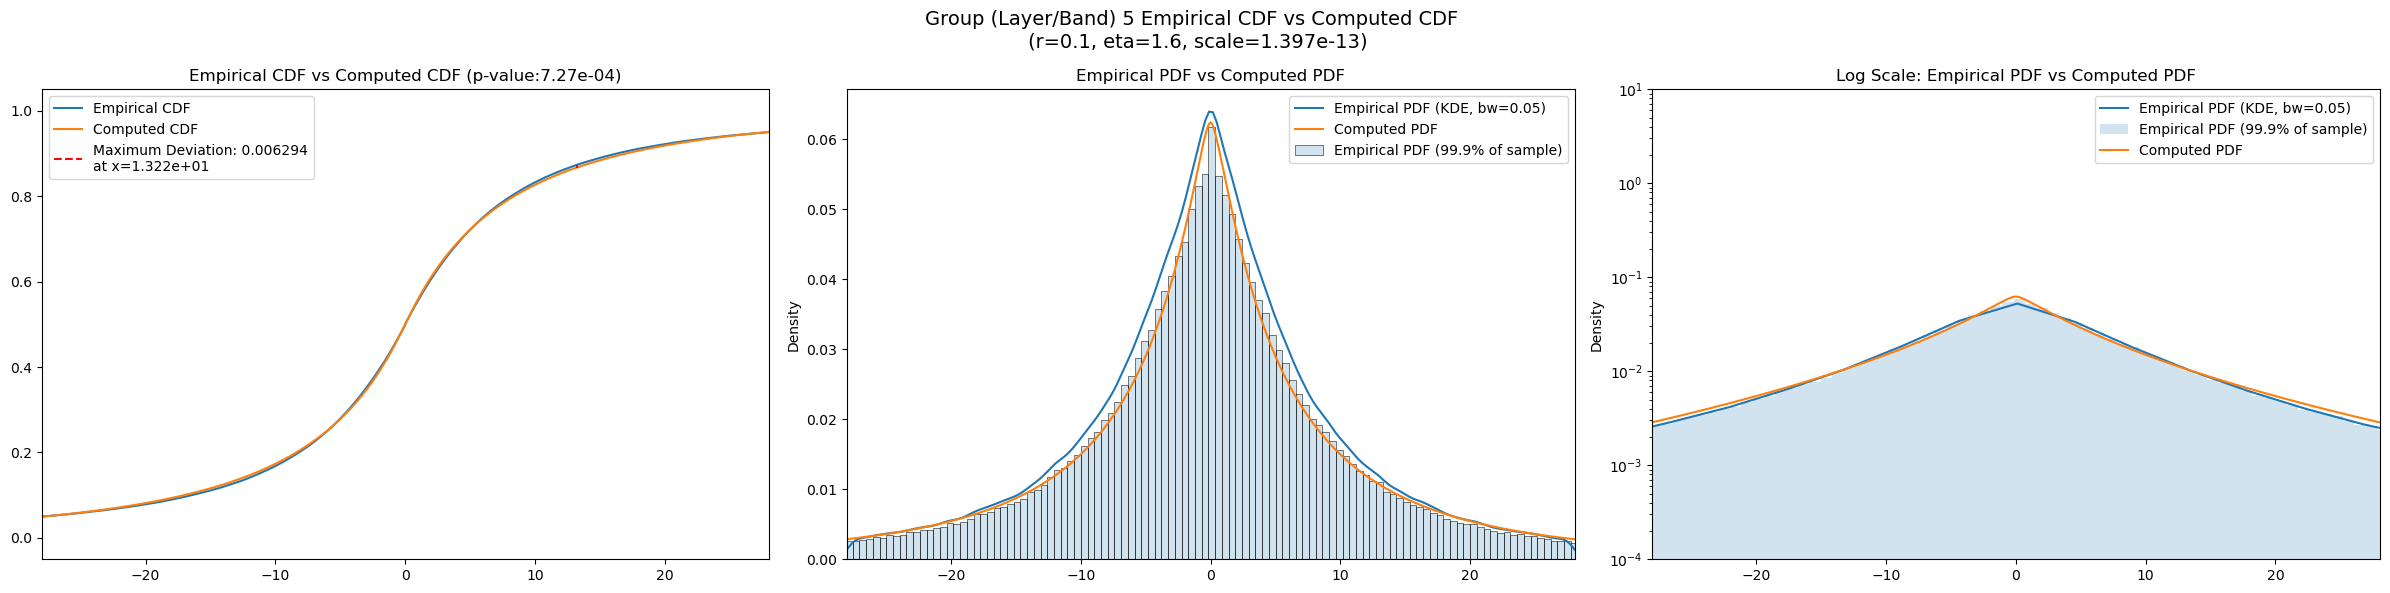

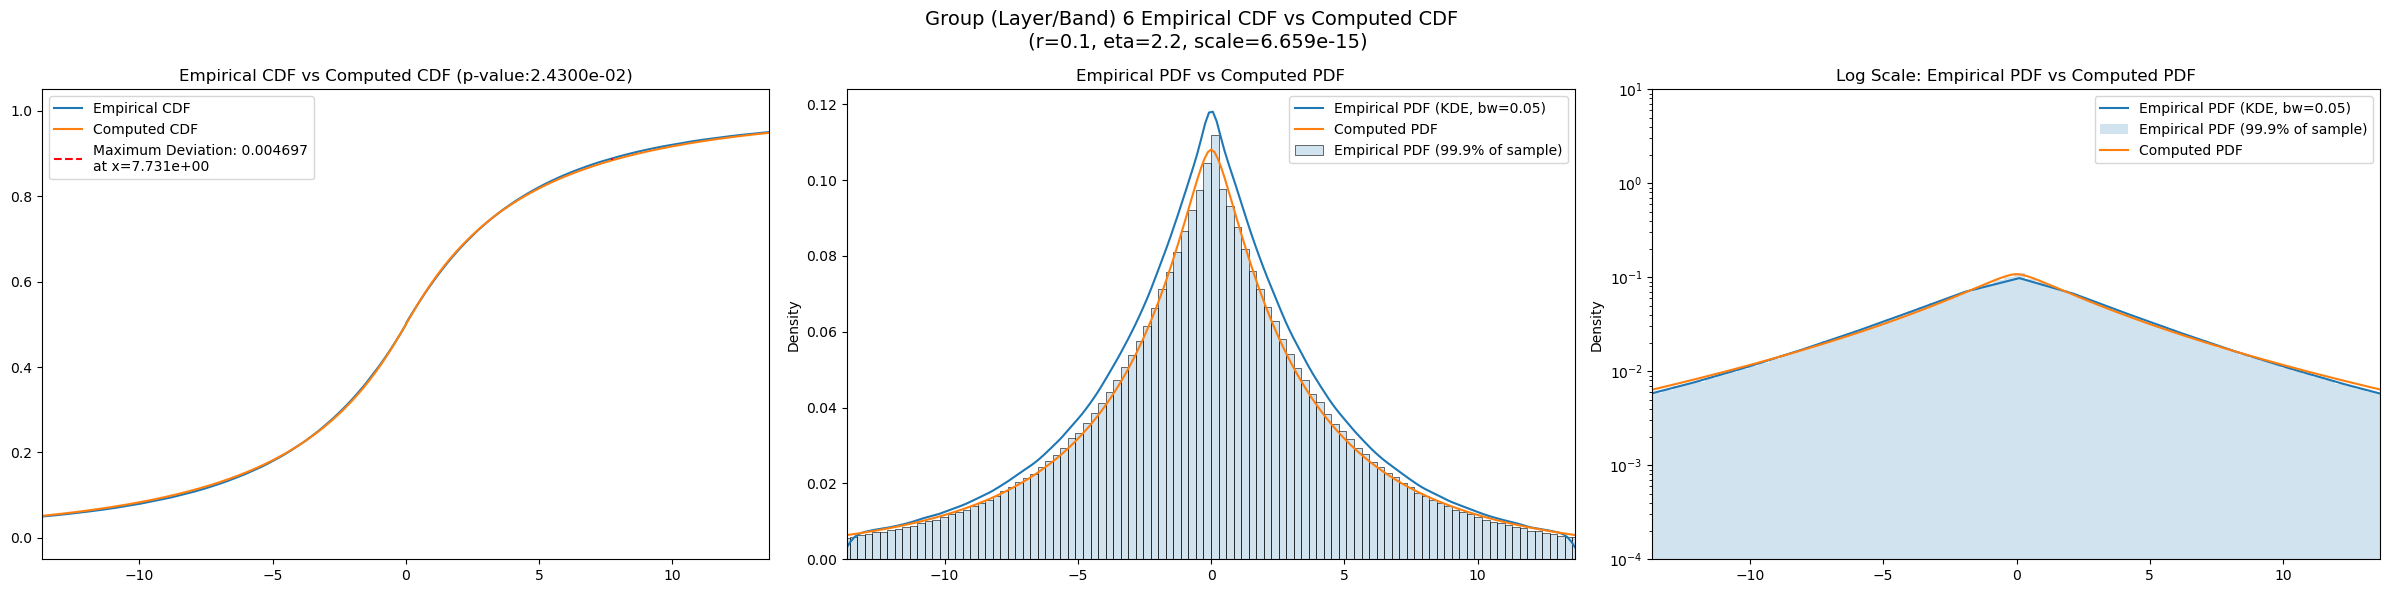

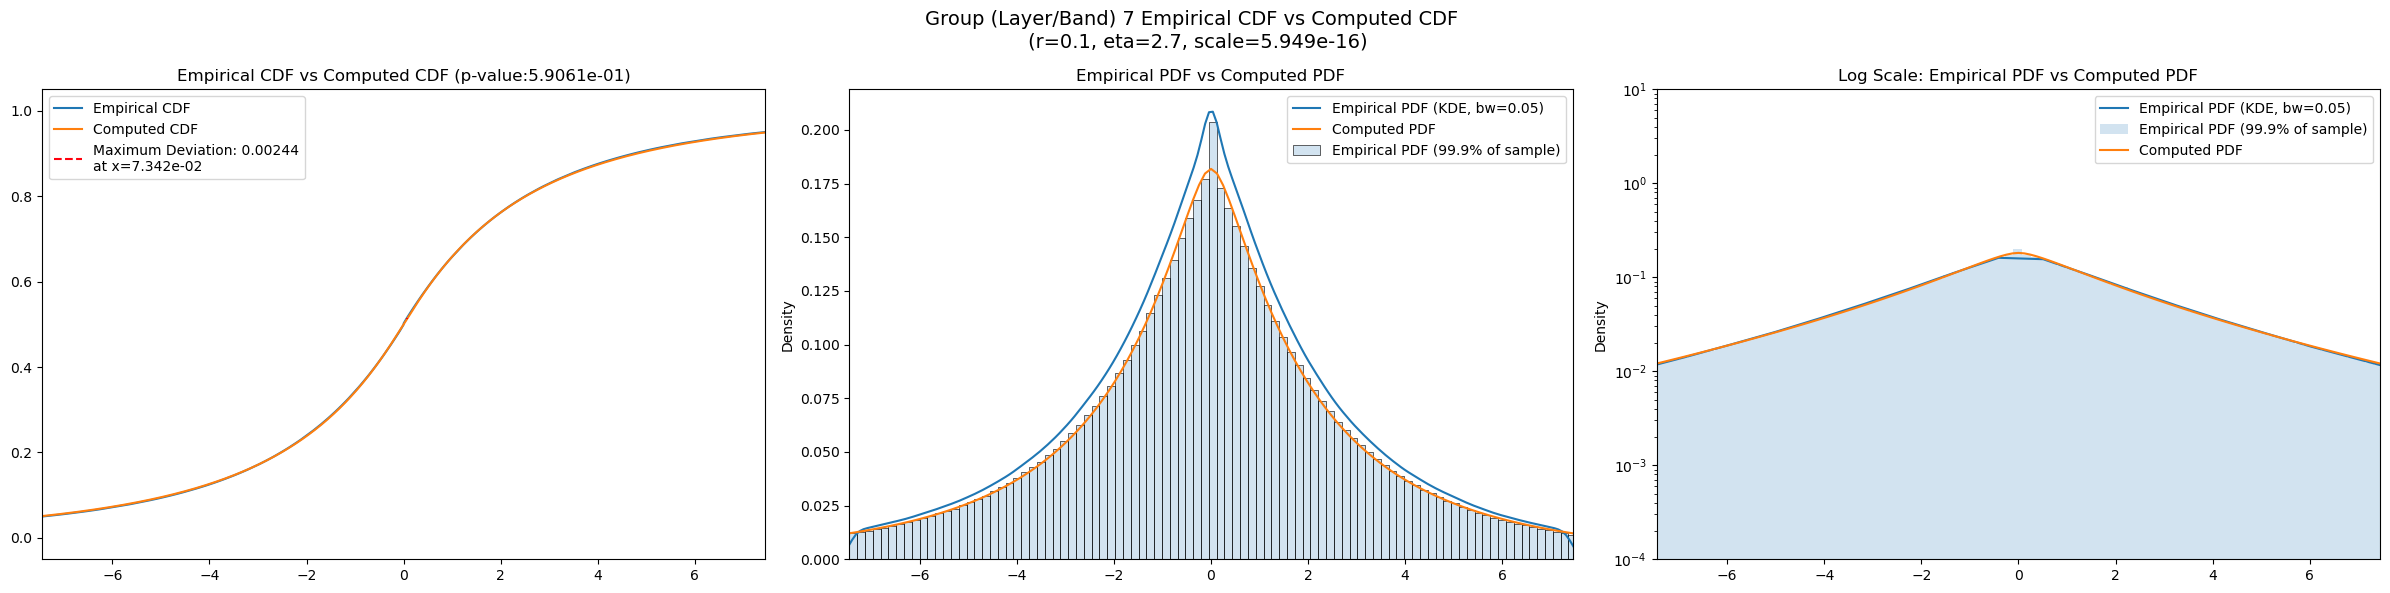

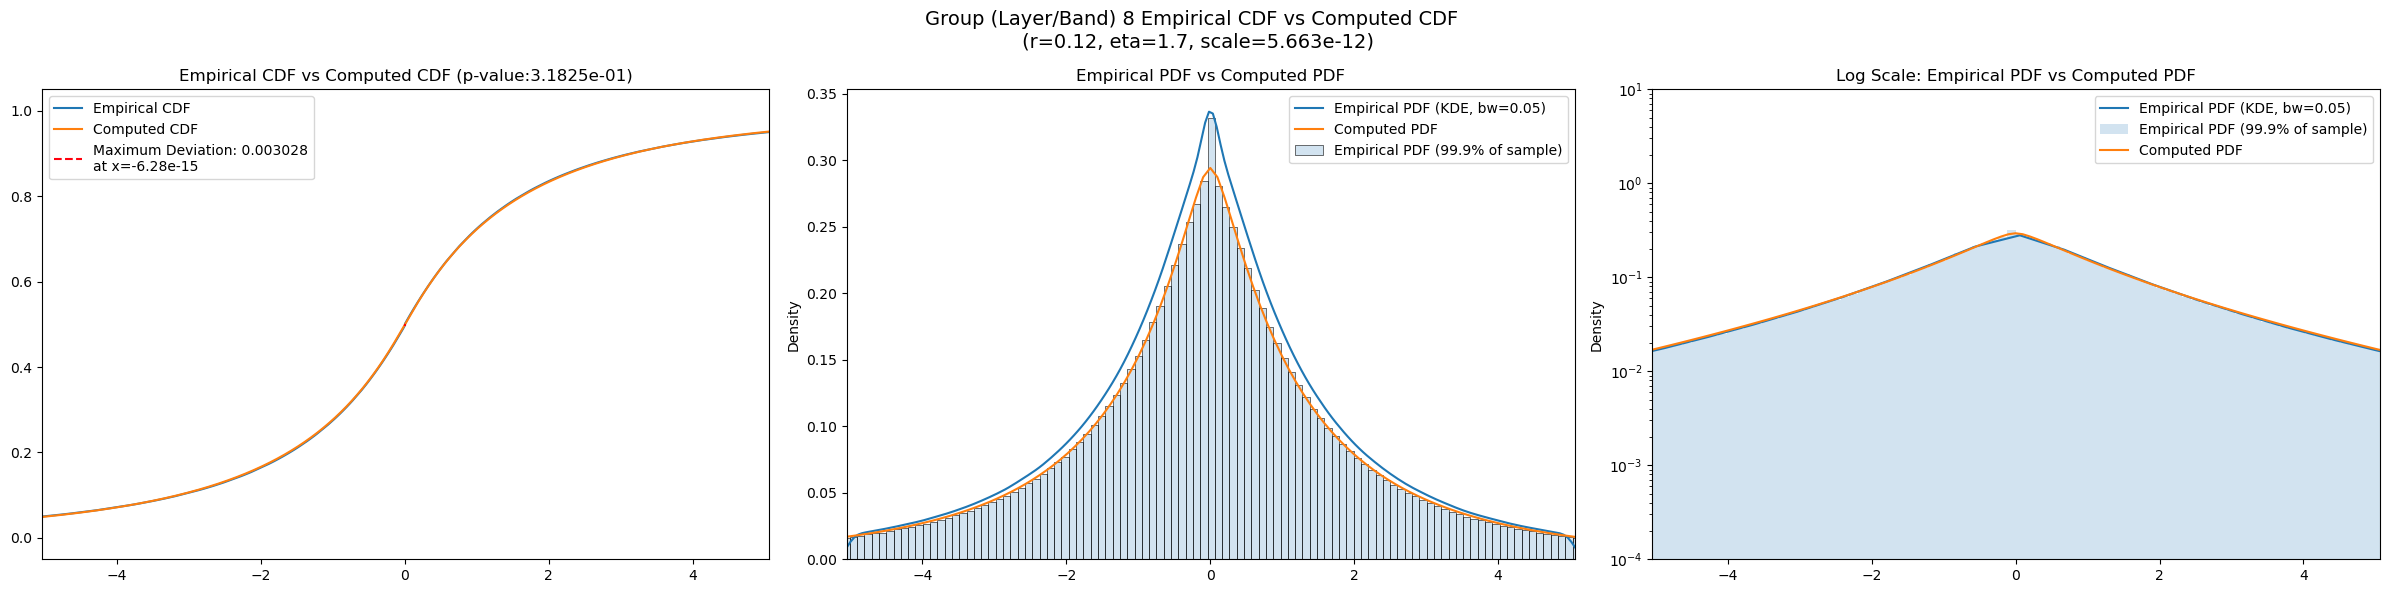

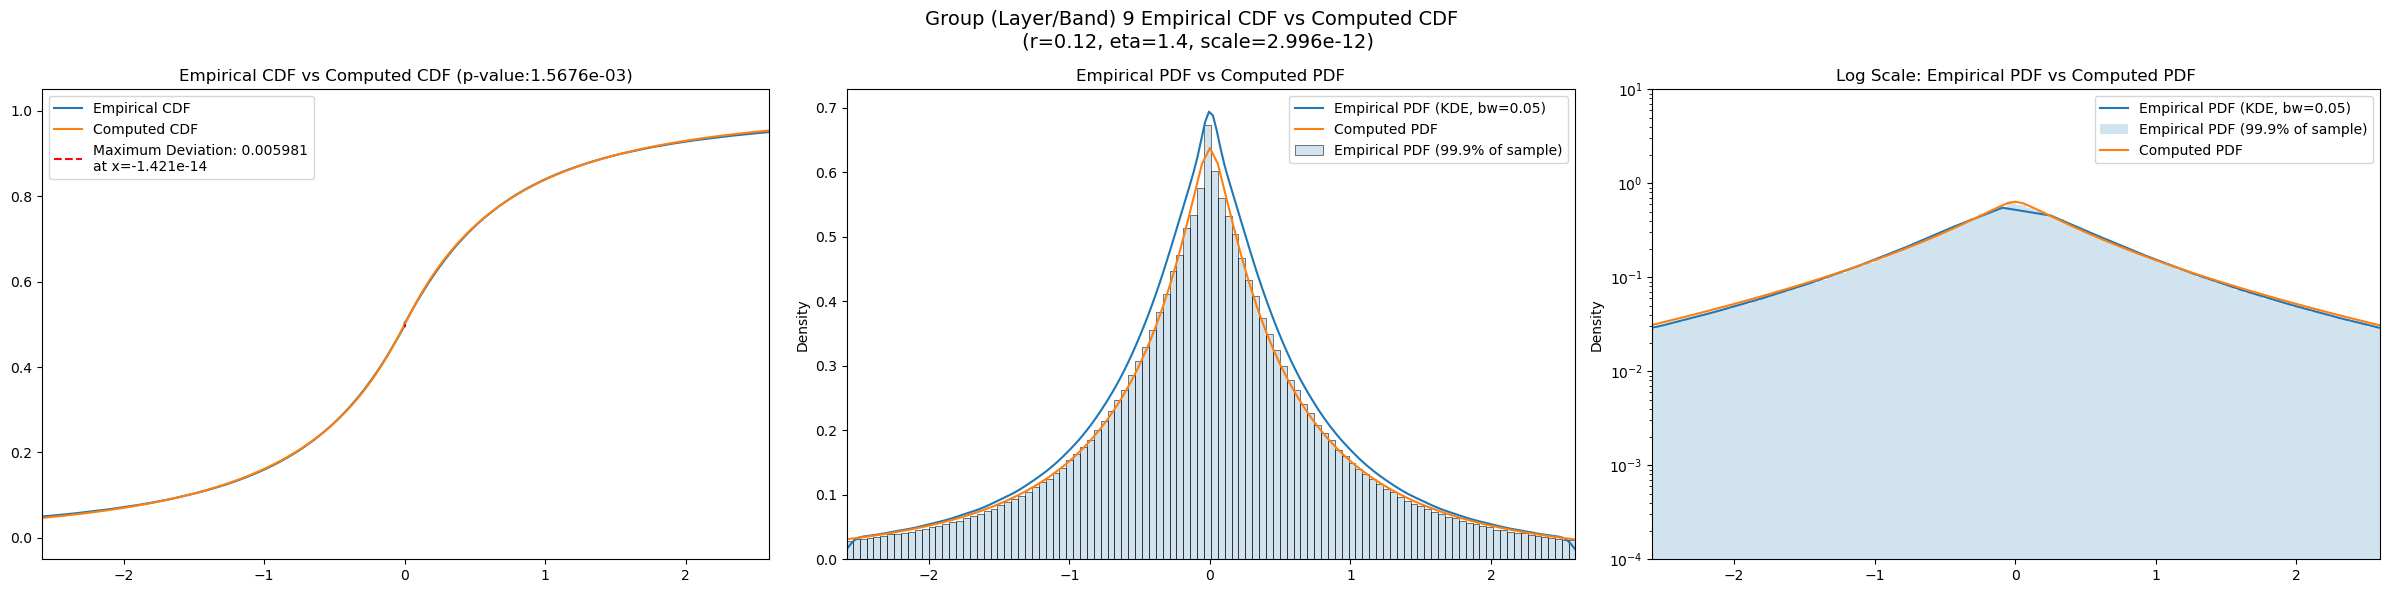

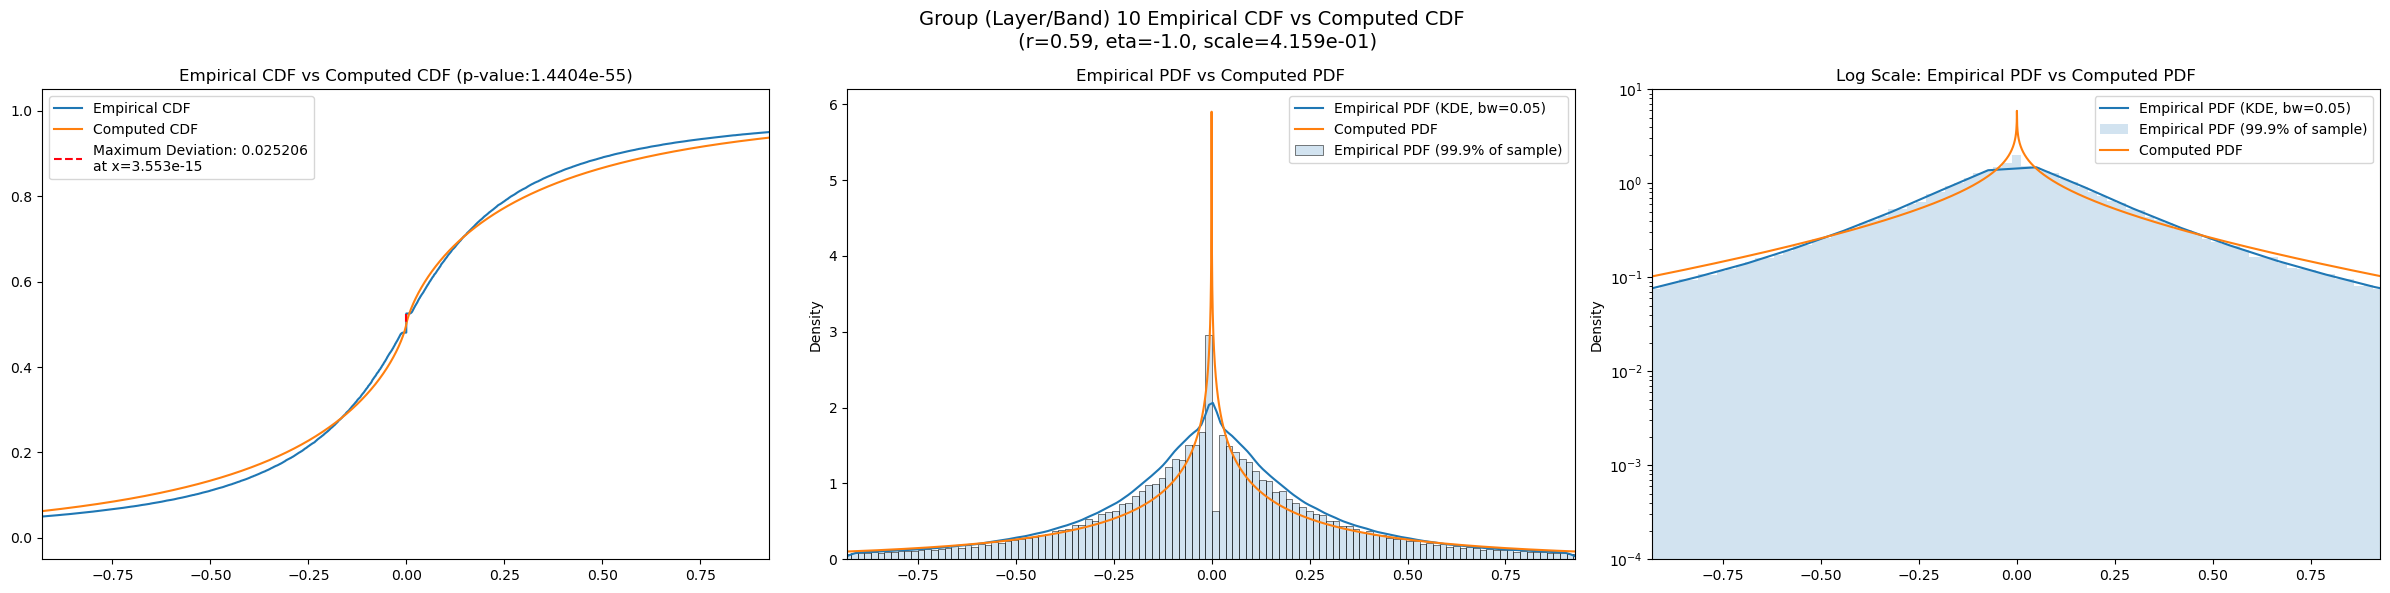

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [19]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                        
2      181300.620000  101526.980000  290784.600000   377.25858  142.297880   
3       38789.977000   21575.424000   67721.520000   543.33215  122.402770   
4        9777.212000    4939.198000   17950.002000   703.37980  122.038475   
5        1796.315800     838.102050    4289.250000  1421.50900   90.012470   
6         385.116970     175.524030    1132.752800  2320.62400   86.752716   
7         101.065820      41.339350     424.445160  4759.82570   66.990580   
8          34.402660      17.916046      89.423820  1601.38330   74.529690   
9           9.889628       5.271114      25.139076  1503.44800   80.922005   
10          1.436547       0.712656       4.498758  2683.97460   76.523470   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       530.93066         9000.0             0.013746        0.1          2.7   
3      1044.48300        36000.0             0.009030        0.1          1.8   
4      1327.72410       144000.0             0.006965        0.1          1.4   
5      3420.72660       576000.0             0.005912        0.1          1.6   
6      4403.35350      2304000.0             0.004299        0.1          2.2   
7      6336.49370      9216000.0             0.003068        0.1          2.6   
8      3574.43000     36864000.0             0.003030        0.1          2.1   
9      3413.64060    147456000.0             0.005980        0.1          1.8   
10     4568.20360    589824000.0             0.025180        0.3         -0.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      133.282000              0.051481          3.597690e-21   
3      ...       54.457900              0.053988          1.223770e-91   
4      ...       23.808300              0.051990          0.000000e+00   
5      ...       11.065200              0.047428          0.000000e+00   
6      ...        5.830510              0.041887          0.000000e+00   
7      ...        3.282180              0.039796          0.000000e+00   
8      ...        2.116210              0.044159          0.000000e+00   
9      ...        1.039060              0.046865          0.000000e+00   
10     ...        0.363332              0.048404          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         118.096000             0.025249         2.039260e-05  92.985200   
3          48.330400             0.027862         1.036610e-24  38.002700   
4          21.201200             0.026671         2.018150e-89  16.522200   
5           9.868200             0.022582        1.331460e-255   7.747850   
6           5.192230             0.016798         0.000000e+00   4.080300   
7           2.906700             0.013695         0.000000e+00   2.314560   
8           1.870820             0.017607         0.000000e+00   1.484000   
9           0.923385             0.021152         0.000000e+00   0.726713   
10          0.317640             0.025180         0.000000e+00   0.261154   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.023651   8.337920e-05          6.603999e-02  
3           0.024767   1.288940e-19          8.018385e-03  
4           0.022998   1.356960e-66          4.118671e-06  
5           0.017724  1.324120e-157          6.468212e-18  
6           0.013527   0.000000e+00          2.055427e-37  
7           0.012877   0.000000e+00          9.800265e-62  
8           0.016166   0.000000e+00         2.142020e-294  
9           0.017855   0.000000e+00          0.000000e+00  

## Results

In [20]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [21]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.013746                 0.014297          0.013746   
3                 0.009030                 0.007153          0.008751   
4                 0.006965                 0.003578          0.006741   
5                 0.005912                 0.001789          0.005912   
6                 0.004299                 0.000895          0.004299   
7                 0.003068                 0.000447          0.002767   
8                 0.003030                 0.000224          0.003030   
9                 0.005980                 0.000112          0.005980   
10                0.025180                 0.000056          0.025180   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.051481             0.025249       0.023651  
3                  0.053988             0.027862       0.024767  
4                  0.051990             0.026671       0.022998  
5                  0.047428             0.022582       0.017724  
6                  0.041887             0.016798       0.013527  
7                  0.039796             0.013695       0.012877  
8                  0.044159             0.017607       0.016166  
9                  0.046865             0.021152       0.017855  
10                 0.048404             0.025180       0.025180

In [22]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            45005.450000          0.013746    0.10       2.7  9.706194e-13   
3            10664.005859          0.008751    0.09       2.0  6.112826e-15   
4             2243.481201          0.006741    0.09       1.7  3.105290e-15   
5              429.708980          0.005912    0.10       1.6  1.396978e-13   
6               98.496640          0.004299    0.10       2.2  6.658661e-15   
7               27.586119          0.002767    0.10       2.7  5.949418e-16   
8               12.334513          0.003030    0.12       1.7  5.663263e-12   
9                3.171036          0.005980    0.12       1.4  2.996181e-12   
10               0.511128          0.025180    0.59      -1.0  4.159152e-01   

       best_exclude_cutoff  
layer                       
2                     50.0  
3                    125.0  
4                    325.0  
5                    300.0  
6                    250.0  
7                    175.0  
8                    150.0  
9                    250.0  
10                   125.0

In [23]:
eng.quit()